In [2]:
import math
import sys

import numpy as np
import torch

import os
basedir = "/home/d/PycharmProjects/protein_properties"
os.chdir(basedir)
import gc

import random
from datetime import date
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import pearsonr
mpl.rcParams['figure.dpi'] = 180

2024-12-20 08:49:18.666032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734680958.810157   25607 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734680958.846414   25607 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 08:49:19.169453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# hyper-parameters
# batch_size = 11
device = torch.device("cpu")
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# LSTM Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers, seq_len,num_classes=1):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.seq_len = seq_len

        self.bnn1 = nn.Linear(input_size, 32)
        self.bnn2 = nn.Linear(32,64)
        self.bnn3 = nn.Linear(64,64)
        self.bnn4 = nn.Linear(64,64)

        self.lstm1 = nn.LSTM(64, hidden_size1, num_layers, batch_first=True, bidirectional=True, dropout=0.5)
        self.bn_lstm1 = nn.BatchNorm1d(2*hidden_size1,device=device)  
        # self.lstm2 = nn.LSTM(2*hidden_size1, hidden_size2, num_layers, batch_first=True, bidirectional=True, dropout=0.5)
        # self.bn_lstm2 = nn.BatchNorm1d(2*hidden_size2,device=device)
        self.nn1 = nn.Linear(2*hidden_size1, 2*hidden_size1)
        self.nn2 = nn.Linear(2*hidden_size1, 512)
        self.nn3 = nn.Linear(512, 512)
        self.nn4 = nn.Linear(512, 256)
        self.nn5 = nn.Linear(256, 256)
        self.nn6 = nn.Linear(256, 128)
        self.nn7 = nn.Linear(128, 32)
        self.nn8 = nn.Linear(32, 1)

    
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # self.batch = nn.BatchNorm1d()
        self.drop = nn.Dropout(p=0.5)


        
    def forward(self, x, array_lengths):
        # Set initial hidden states (and cell states for LSTM)
        # print(x.size(0))
        inital_seq_len = x.size(1)
        x = Variable(x.float()).to(device)

        x = torch.reshape(x, (x.size(0)*x.size(1), x.size(2)))

        ## before nn
        out = self.bnn1(x)
        out = self.relu(out)
        out = self.bnn2(out)
        out = self.relu(out)
        out = self.bnn3(out)
        out = self.relu(out)
        out = self.bnn4(out)
        out = self.relu(out)

        ## reshaping again
        out = torch.reshape(out, (-1, inital_seq_len, out.size(1)))
        # print(out.size())
        # print(aaaaa)

        # out = torch.permute(out, (0,2,1))
        
        pack = nn.utils.rnn.pack_padded_sequence(out, array_lengths, batch_first=True, enforce_sorted=False)
        h0 = Variable(torch.zeros(2*self.num_layers, x.size(0), self.hidden_size1).to(device))
        c0 = Variable(torch.zeros(2*self.num_layers, x.size(0), self.hidden_size1).to(device))
        h1 = Variable(torch.zeros(2*self.num_layers, self.hidden_size1, self.hidden_size2).to(device))
        c1 = Variable(torch.zeros(2*self.num_layers, self.hidden_size1, self.hidden_size2).to(device))
        
        # Forward propagate RNN
        out, _ = self.lstm1(pack, (h0,c0))
        del(h0)
        del(c0)
        # out, _ = self.lstm2(out, (h1,c1))
        gc.collect()
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        this_batch_len = unpacked.size(1)
        out = unpacked
        # print('before', out.size())
        out = torch.reshape(out, (out.size(0)*out.size(1), out.size(2)))

        ##nn
        out = self.nn1(out)
        out = self.relu(out)
        out = self.nn2(out)
        out = self.relu(out)
        out = self.nn3(out)
        out = self.relu(out)
        out = self.nn4(out)
        out = self.relu(out)
        out = self.nn5(out)
        out = self.relu(out)
        out = self.nn6(out)
        out = self.relu(out)
        out = self.nn7(out)
        out = self.relu(out)
        out = self.nn8(out)
        
        ## reshaping
        out = torch.reshape(out, (-1, this_batch_len, 1))
        # print(out.size()) 
        # print(aaaaa)   
        

        return out

In [5]:
input_size = 28
hidden_size1 = 512
hidden_size2 = 64
num_layers = 1
init_lr = 0.001
num_epochs = 400
seq_len = 500

epoch_check =98
print('Device is',device)

model_test_weights = torch.load(f'checkpoints/Pandey_bfactor_epoch_{epoch_check}_no_rr.pth')
model_test = RNN(input_size, hidden_size1, hidden_size2, num_layers, seq_len).to(device)
model_test.load_state_dict(model_test_weights)
model_test.eval().to(device)

model_test_rr_weights = torch.load(f'checkpoints/Pandey_bfactor_epoch_{epoch_check}_rr.pth', map_location=device)
model_test_rr = RNN(input_size, hidden_size1, hidden_size2, num_layers, seq_len).to(device)
model_test_rr.load_state_dict(model_test_rr_weights)
model_test_rr.eval().to(device)

Device is cpu


/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RNN(
  (bnn1): Linear(in_features=28, out_features=32, bias=True)
  (bnn2): Linear(in_features=32, out_features=64, bias=True)
  (bnn3): Linear(in_features=64, out_features=64, bias=True)
  (bnn4): Linear(in_features=64, out_features=64, bias=True)
  (lstm1): LSTM(64, 512, batch_first=True, dropout=0.5, bidirectional=True)
  (bn_lstm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nn1): Linear(in_features=1024, out_features=1024, bias=True)
  (nn2): Linear(in_features=1024, out_features=512, bias=True)
  (nn3): Linear(in_features=512, out_features=512, bias=True)
  (nn4): Linear(in_features=512, out_features=256, bias=True)
  (nn5): Linear(in_features=256, out_features=256, bias=True)
  (nn6): Linear(in_features=256, out_features=128, bias=True)
  (nn7): Linear(in_features=128, out_features=32, bias=True)
  (nn8): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
  (drop): Dropout(p=0.5, inplace=False)
)

In [5]:
"""t =  np.load('../../data/pandey_bfactor/y_61046.npy', allow_pickle=True)
t.shape"""

"t =  np.load('../../data/pandey_bfactor/y_61046.npy', allow_pickle=True)\nt.shape"

In [6]:
"""# partially load numpy array
a = np.load('../../data/pandey_bfactor/x_61046.npy', allow_pickle=True, mmap_mode='r')
print(a.shape)"""


"# partially load numpy array\na = np.load('../../data/pandey_bfactor/x_61046.npy', allow_pickle=True, mmap_mode='r')\nprint(a.shape)"

In [7]:
# pad y to 500
def pad_test_y(y):
    ys = []
    for i in range(len(y)):
        ys.append(np.pad(y[i], (0, 500-len(y[i])), 'constant', constant_values=(-100, -100)))
    assert len(ys) == len(y)
    assert all([len(y) == 500 for y in ys])
    y = np.array(ys).reshape(-1, 500, 1)
    return y


In [8]:
test_path = Path('data/pandey_bfactor/test_time/')

test_features = np.load(test_path / 'test_seqs_bfactor_full_features.npy', allow_pickle=True)
np.nan_to_num(test_features, copy=False)
test_bfactor = np.load(test_path / 'test_seqs_bfactor_y.npy', allow_pickle=True)
with open(test_path / 'test_seqs_protein_list.txt', 'r') as f:
    test_ids = f.read().splitlines()
# remove proteins that consist only of None values
test_mask = test_bfactor != None
test_features = test_features[test_mask]
test_bfactor = test_bfactor[test_mask]
test_ids = [test_ids[i] for i in range(len(test_ids)) if test_mask[i]]
test_bfactor = pad_test_y(test_bfactor)
print(test_features.shape, test_bfactor.shape, len(test_ids))


(533,) (533, 500, 1) 533


In [9]:
test_MM165 = np.load(test_path / 'MM165_seqs_bfactor_full_features.npy', allow_pickle=True)
np.nan_to_num(test_MM165, copy=False)
test_MM165_bfactor = np.load(test_path / 'MM165_seqs_bfactor_y.npy', allow_pickle=True)
with open(test_path / 'MM165_seqs_protein_list.txt', 'r') as f:
    test_MM165_ids = f.read().splitlines()
MM165_mask = test_MM165_bfactor != None
test_MM165 = test_MM165[MM165_mask]
test_MM165_bfactor = test_MM165_bfactor[MM165_mask]
test_MM165_ids = [test_MM165_ids[i] for i in range(len(test_MM165_ids)) if MM165_mask[i]]
test_MM165_bfactor = pad_test_y(test_MM165_bfactor)
print(test_MM165.shape, test_MM165_bfactor.shape, len(test_MM165_ids))

(136,) (136, 500, 1) 136


In [10]:
test_MM23 = np.load(test_path / 'MM23_seqs_bfactor_full_features.npy', allow_pickle=True)
np.nan_to_num(test_MM23, copy=False)
test_MM23_bfactor = np.load(test_path / 'MM23_seqs_bfactor_y.npy', allow_pickle=True)
with open(test_path / 'MM23_seqs_protein_list.txt', 'r') as f:
    test_MM23_ids = f.read().splitlines()
MM23_mask = test_MM23_bfactor != None
test_MM23 = test_MM23[MM23_mask]
test_MM23_bfactor = test_MM23_bfactor[MM23_mask]
test_MM23_ids = [test_MM23_ids[i] for i in range(len(test_MM23_ids)) if MM23_mask[i]]
test_MM23_bfactor = pad_test_y(test_MM23_bfactor)
print(test_MM23.shape, test_MM23_bfactor.shape, len(test_MM23_ids))

(20,) (20, 500, 1) 20


In [11]:
test_CASP12 = np.load(test_path / 'CASP12_seqs_bfactor_full_features.npy', allow_pickle=True)
np.nan_to_num(test_CASP12, copy=False)
test_CASP12_bfactor = np.load(test_path / 'CASP12_seqs_bfactor_y.npy', allow_pickle=True)
with open(test_path / 'CASP12_seqs_protein_list.txt', 'r') as f:
    test_CASP12_ids = f.read().splitlines()
CASP12_mask = test_CASP12_bfactor != None
test_CASP12 = test_CASP12[CASP12_mask]
test_CASP12_bfactor = test_CASP12_bfactor[CASP12_mask]
test_CASP12_ids = [test_CASP12_ids[i] for i in range(len(test_CASP12_ids)) if CASP12_mask[i]]
test_CASP12_bfactor = pad_test_y(test_CASP12_bfactor)
print(test_CASP12.shape, test_CASP12_bfactor.shape, len(test_CASP12_ids))

(10,) (10, 500, 1) 10


In [12]:
test_CASP14 = np.load(test_path / 'CASP14_seqs_bfactor_full_features.npy', allow_pickle=True)
np.nan_to_num(test_CASP14, copy=False)
test_CASP14_bfactor = np.load(test_path / 'CASP14_seqs_bfactor_y.npy', allow_pickle=True)
with open(test_path / 'CASP14_seqs_protein_list.txt', 'r') as f:
    test_CASP14_ids = f.read().splitlines()
CASP14_mask = test_CASP14_bfactor != None
test_CASP14 = test_CASP14[CASP14_mask]
test_CASP14_bfactor = test_CASP14_bfactor[CASP14_mask]
test_CASP14_ids = [test_CASP14_ids[i] for i in range(len(test_CASP14_ids)) if CASP14_mask[i]]
test_CASP14_bfactor = pad_test_y(test_CASP14_bfactor)
print(test_CASP14.shape, test_CASP14_bfactor.shape, len(test_CASP14_ids))

(0,) (0, 500, 1) 0


In [13]:
b_dist = test_bfactor.squeeze().reshape(-1, 1)
b_dist = b_dist[b_dist != -100]
print(b_dist.mean())
print(b_dist.std())

1.1395966892899788e-17
1.0


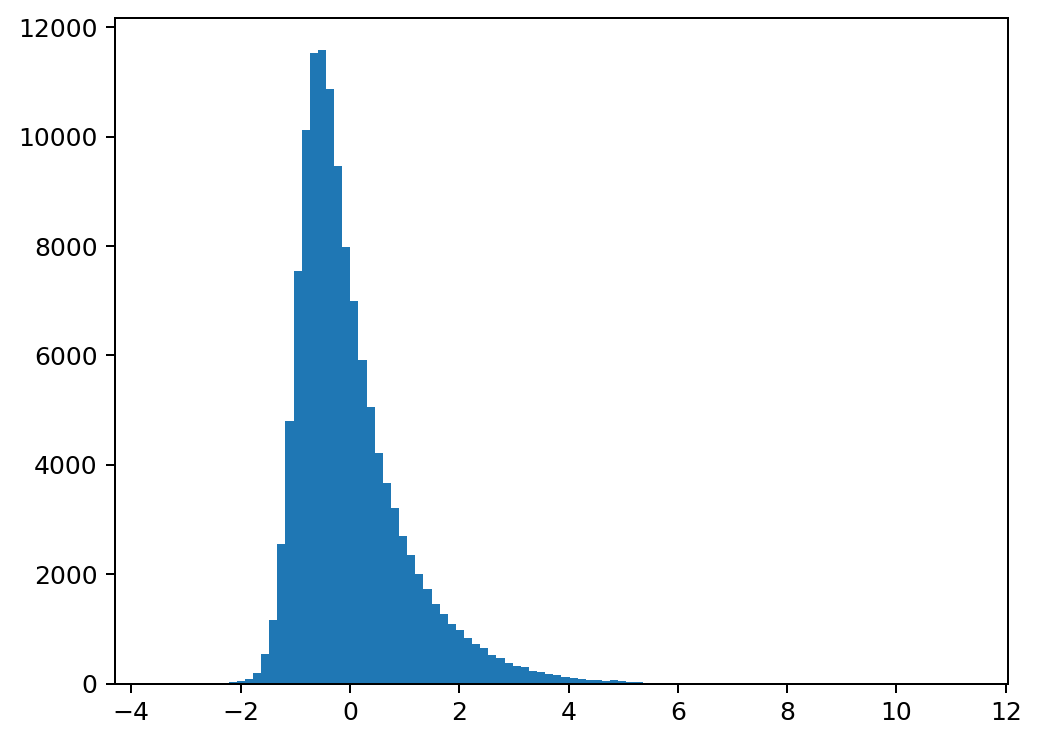

In [14]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(b_dist, bins=100)
plt.show()

In [15]:
# dataset preparation
class BetaDataset(Dataset) :
    def __init__(self,x,y, n_samples) :
        # data loading
        self.x = x
        self.y = y 
        self.n_samples = n_samples
       
        
    def __getitem__(self,index) :
        return self.x[index], self.y[index]

    def __len__(self) :    
        return self.n_samples      

test_data = BetaDataset(test_features, test_bfactor, len(test_features))
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

MM165_data = BetaDataset(test_MM165, test_MM165_bfactor, len(test_MM165))
MM165_loader = DataLoader(dataset=MM165_data, batch_size=1, shuffle=False)

MM23_data = BetaDataset(test_MM23, test_MM23_bfactor, len(test_MM23))
MM23_loader = DataLoader(dataset=MM23_data, batch_size=1, shuffle=False)

CASP12_data = BetaDataset(test_CASP12, test_CASP12_bfactor, len(test_CASP12))
CASP12_loader = DataLoader(dataset=CASP12_data, batch_size=1, shuffle=False)

'''test_dataset = BetaDataset(full_test_feature_bfactor, test_y, np.shape(full_test_feature_bfactor)[0])
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)'''


'test_dataset = BetaDataset(full_test_feature_bfactor, test_y, np.shape(full_test_feature_bfactor)[0])\ntest_loader = DataLoader(dataset=test_dataset,\n                          batch_size=128,\n                          shuffle=False,\n                          num_workers=1)'

In [16]:
# combined = np.zeros((1,a_ebya))
def plot_scatter(a_beta, p_beta, avg_pearson):
    with torch.no_grad():
        plt.figure(1)
        # plt.rcParams.update({'font.size': 16})
        plt.scatter(a_beta.cpu(), p_beta.cpu(), s=0.1)
        plt.plot(a_beta.cpu(), a_beta.cpu(),'k')
        plt.title(f'Average PCC:{round(avg_pearson,2)}, $R^2$:{round(r2_score(a_beta.cpu(), p_beta.cpu()),2)}')
        # plt.plot(p_beta[50000:100000].cpu())s
        plt.xlabel(r'Actual Normalized Beta factor', fontsize=12)
        plt.ylabel(r'Predicted Normalized Beta factor', fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        # plt.xlim([0,80])
        # plt.ylim([0,80])
        plt.show()

In [17]:
from math import nan


def test(model_test, test_loader, test_dataset):
  # test_loader = test_loader[15:20,:]
  devive = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  p_beta = torch.zeros((1)).to(device)
  a_beta = torch.zeros((1)).to(device)
  collection_test = 0
  avg_pearson_count = 0
  avg_pearson = 0
  avg_r2 = 0
  count_all = 0
  pearson_coeff = torch.zeros((len(test_dataset), ))
  pearson_count = 0
  with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
      # parameters = parameters.to(device)
      #----------------------------------------------
      #!DEBUG
      """input_x = torch.from_numpy(all_x[parameters,:,:]).to(device)
      output_y = torch.from_numpy(all_y[parameters,:,:]).to(device)
      input_x = torch.reshape(input_x, (input_x.size(0), input_x.size(2), input_x.size(3)))
      output_y = torch.reshape(output_y, (output_y.size(0), output_y.size(2), output_y.size(3)))"""
      #!DEBUG
      #----------------------------------------------
      input_x = torch.nan_to_num(x, nan=0.0).to(device)
      
      output_y = y.to(device)
      
      
      # forward pass  
      array_lengths = input_x[:,0,28]
      array_lengths = array_lengths.int()
      array_lengths = array_lengths.tolist()
      outputs = model_test(input_x[:,:,0:28], array_lengths)
      
      outputs = torch.reshape(outputs, (-1,int(max(array_lengths))) )
      output_y = torch.reshape(output_y[:,0:int(max(array_lengths)), 0], (-1,int(max(array_lengths))))
      output_y_mask = output_y != -100  
      output_y = output_y[output_y_mask]
      outputs = outputs[output_y_mask]

      '''outputs = outputs.T
      output_y = output_y.T'''

      for j in range(input_x.size()[0]):    
        #prot_len = int(input_x[j,0,28].item())
        prot_len = len(output_y)
        # print(prot_len)
        if prot_len != 0:
          '''a_beta = torch.cat((torch.flatten(output_y[0:prot_len,j].float()), a_beta.float()),0)
          p_beta = torch.cat((torch.flatten(outputs[0:prot_len,j].float()), p_beta.float()),0)'''
          a_beta = torch.cat((output_y.float(), a_beta.float()),0)
          p_beta = torch.cat((outputs.float(), p_beta.float()),0)
          if math.isnan(np.corrcoef(outputs.cpu(), output_y.cpu())[0,1]):
            print('nan')
          else:
            # print(np.corrcoef(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu())[0,1])
            avg_pearson =  (avg_pearson*avg_pearson_count + np.corrcoef(outputs.cpu(), output_y.cpu())[0,1])/(avg_pearson_count+1)
            avg_r2 = (avg_r2*avg_pearson_count + r2_score(outputs.cpu(), output_y.cpu()))/(avg_pearson_count+1)
            avg_pearson_count += 1
            count_all = count_all + prot_len
            
            pearson_coeff[pearson_count,] = np.corrcoef(outputs.cpu(), output_y.cpu())[0,1]
            pearson_count += 1
            '''if pearson_coeff[pearson_count-1,] < 0.0:
              print(prot_len)
              print(pearson_coeff[pearson_count-1,])'''
              # plt.plot(outputs[0:prot_len,j].cpu())
              # plt.plot(output_y[0:prot_len,j].cpu(), label='actual')
              # plt.legend()
              # plt.show()

      # print(torch.flatten(outputs.float()).size())

      # a_beta = torch.cat((torch.flatten(output_y.float()), a_beta.float()),0)
      # p_beta = torch.cat((torch.flatten(outputs.float()), p_beta.float()),0)

      
      del(input_x)
      del(output_y)
      gc.collect()

  a_beta = a_beta[1:,]
  p_beta = p_beta[1:,]

  print('Total data collected', a_beta.size(0))
  print('Total data predicted', p_beta.size(0))
  # print('Total point should be',count_all)
  print('Avgerage Pearson coefficient is', avg_pearson)
  print('min', torch.min(pearson_coeff[0:pearson_count]))
  print('max', torch.max(pearson_coeff[0:pearson_count]))
  plot_scatter(a_beta, p_beta, avg_pearson)
  return pearson_coeff[:pearson_count]

/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


nan


/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


nan
Total data collected 30799
Total data predicted 30799
Avgerage Pearson coefficient is 0.4652129314892501
min tensor(-0.5421)
max tensor(0.9021)


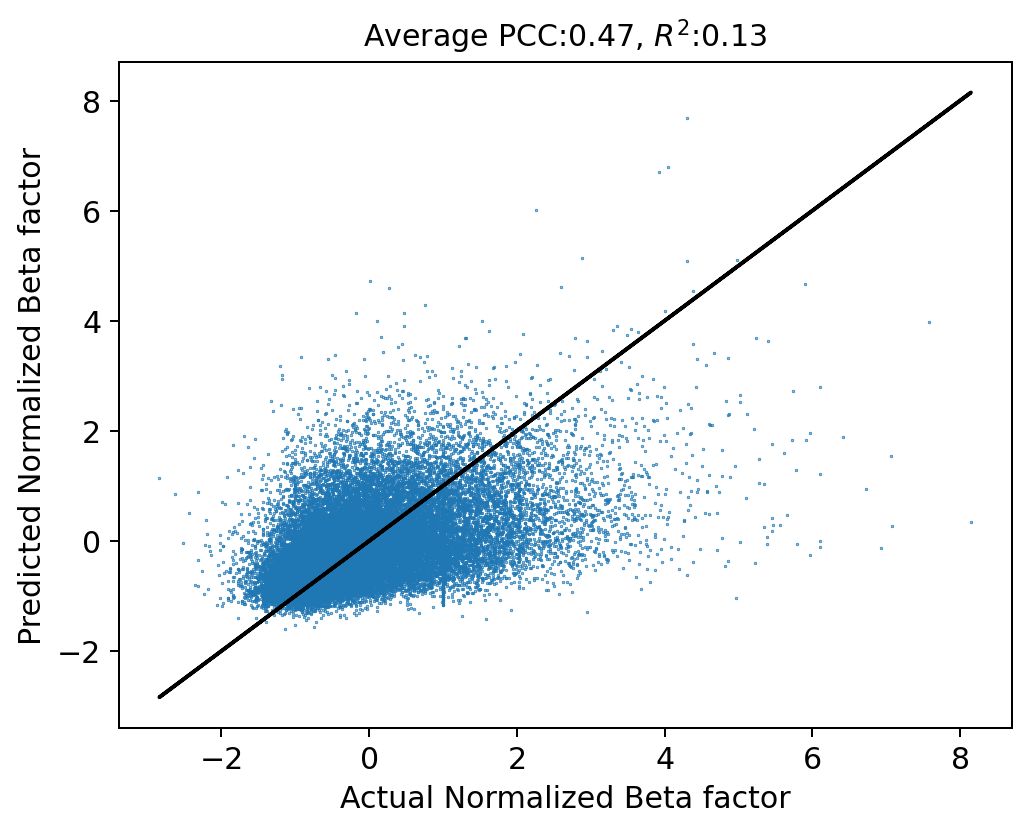

In [18]:
mm165_pandey_pcc = test(model_test, MM165_loader, MM165_data)

Total data collected 5091
Total data predicted 5091
Avgerage Pearson coefficient is 0.4891913151186197
min tensor(0.2216)
max tensor(0.7386)


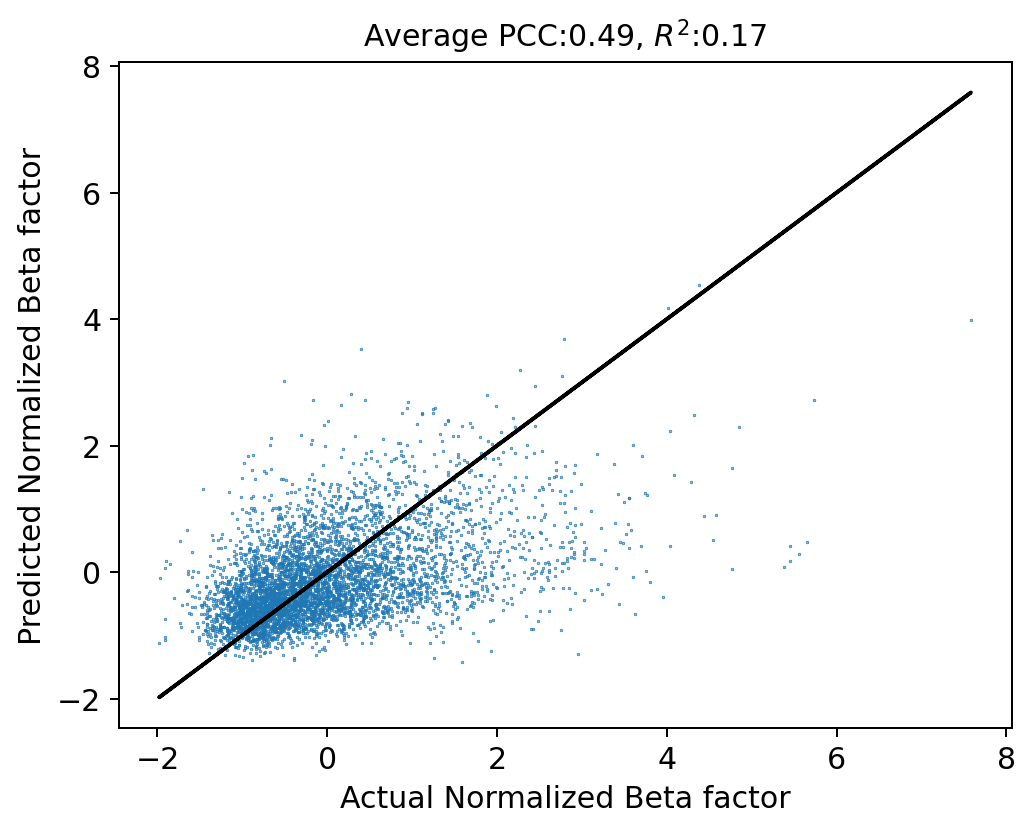

In [19]:
mm23_pandey_pcc = test(model_test, MM23_loader, MM23_data)

Total data collected 2092
Total data predicted 2092
Avgerage Pearson coefficient is 0.47226242457020795
min tensor(0.3326)
max tensor(0.6132)


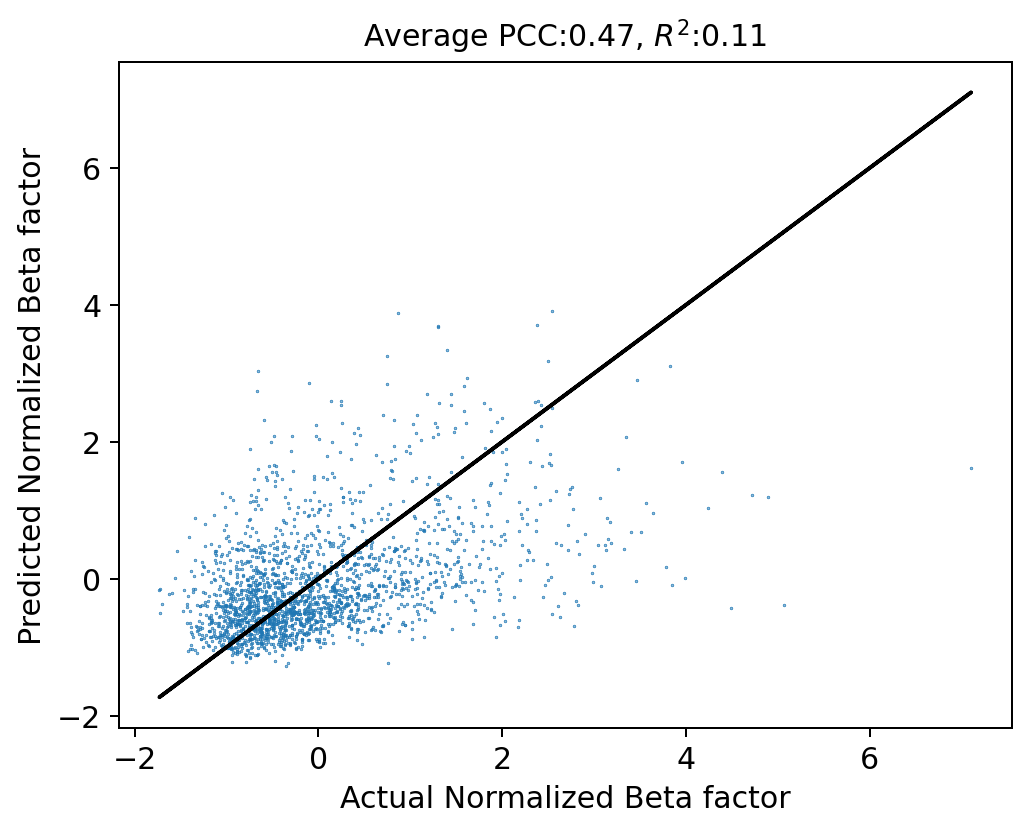

In [20]:
casp12_pandey_pcc = test(model_test, CASP12_loader, CASP12_data)

/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


nan


/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


nan
Total data collected 30799
Total data predicted 30799
Avgerage Pearson coefficient is 0.49250788750282926
min tensor(-0.6268)
max tensor(0.8596)


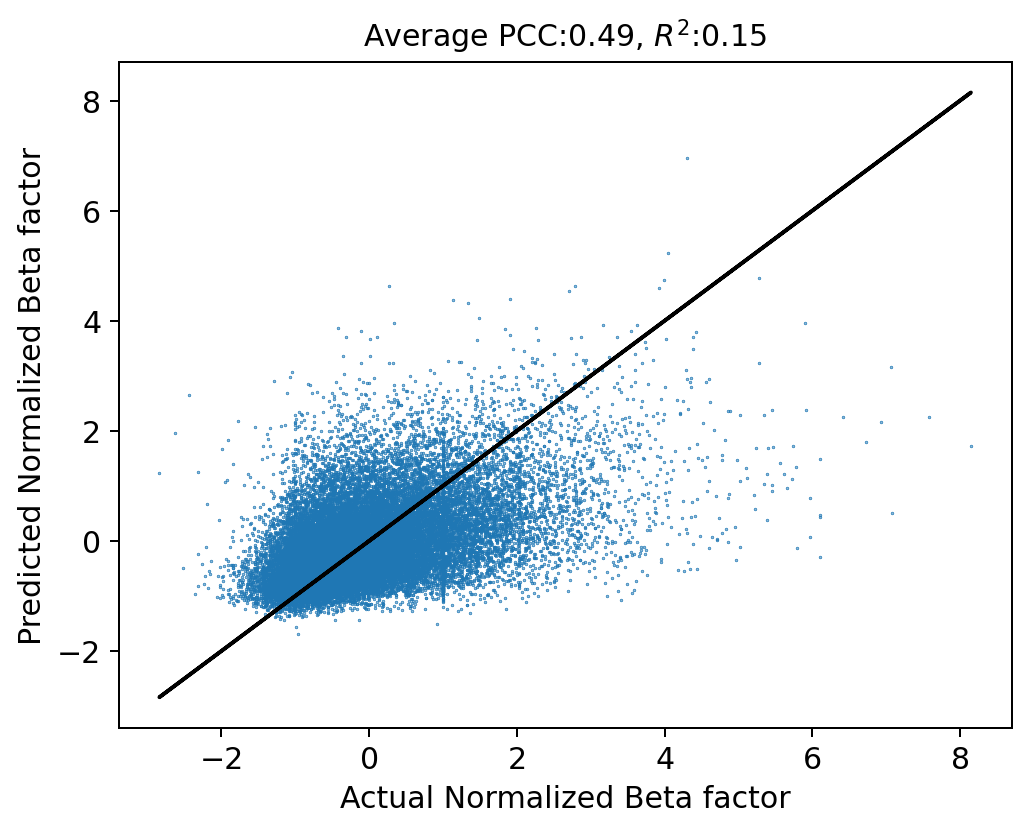

In [21]:
mm165_pandey_RR_pcc = test(model_test_rr, MM165_loader, MM165_data)

Total data collected 5091
Total data predicted 5091
Avgerage Pearson coefficient is 0.5351993122171502
min tensor(0.3197)
max tensor(0.8440)


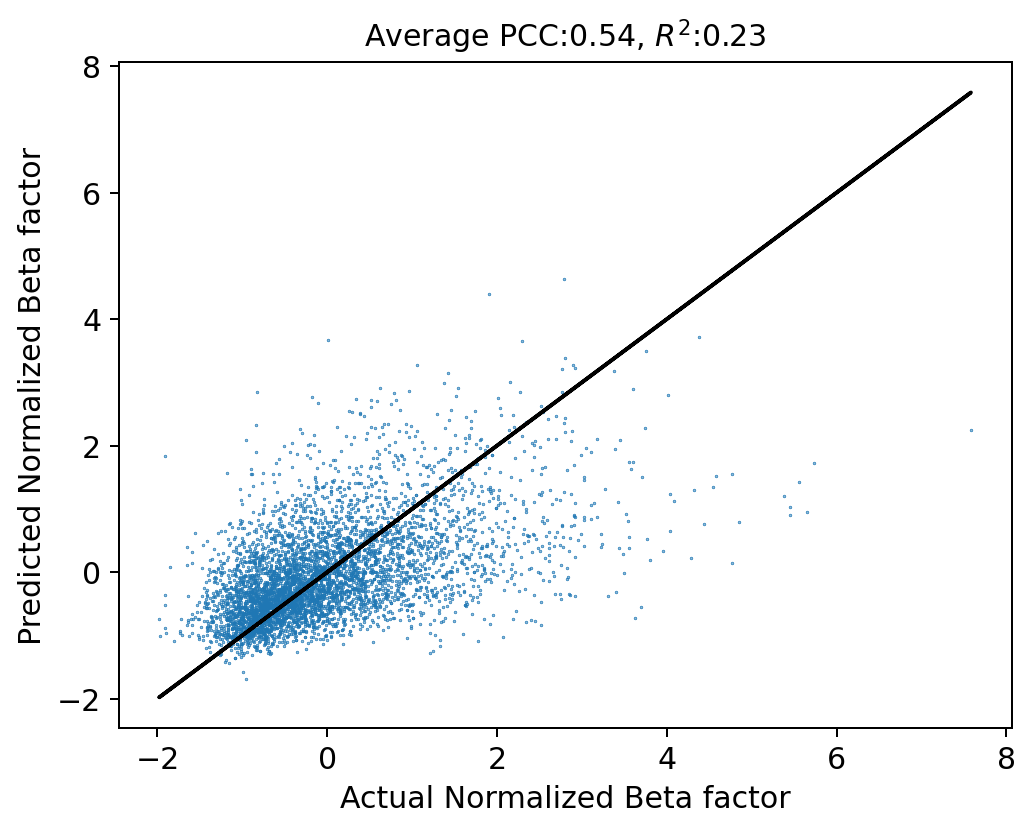

In [22]:
mm23_pandey_RR_pcc = test(model_test_rr, MM23_loader, MM23_data)

Total data collected 2092
Total data predicted 2092
Avgerage Pearson coefficient is 0.41596750321263853
min tensor(0.1784)
max tensor(0.6062)


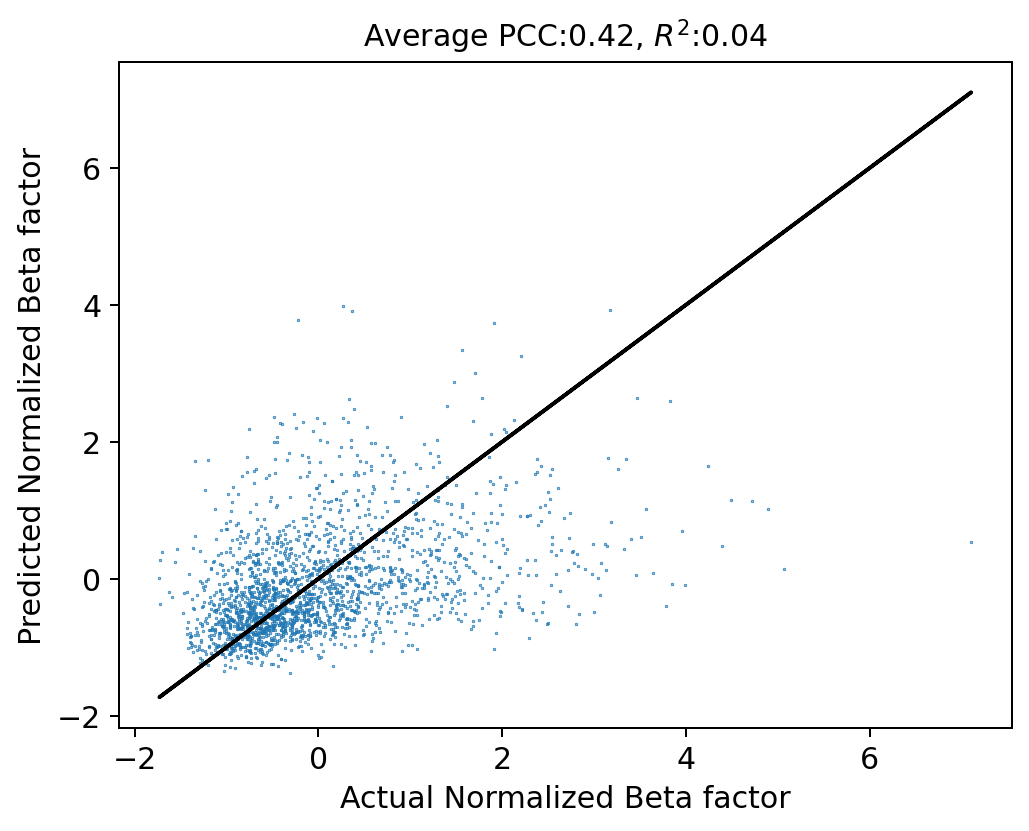

In [23]:
casp12_pandey_RR_pcc = test(model_test_rr, CASP12_loader, CASP12_data)

## Our Model

In [24]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from pathlib import Path
from torch.utils.data import DataLoader, Dataset, Sampler
import torch

import h5py
basedir = "/home/d/PycharmProjects/protein_properties"
os.chdir(basedir)
import torch.nn as nn
from src.utils import mean_confidence_interval
from src.models import *

In [25]:
class BDataset(Dataset):
    def __init__(self, input_features, ys, pids):
        self.input_features = input_features
        self.ys = ys
        self.pids = pids

    def __len__(self):
        return len(self.ys)

    def __getitem__(self, idx):
        if self.__len__() == 1:
            return self.input_features, self.ys, self.pids
        return self.input_features[idx], self.ys[idx], self.pids[idx]

In [26]:
def load_dataset(csv_file, embed_dir, embed_type):
    data = pd.read_csv(csv_file, sep='\t')
    embed_dir = Path(embed_dir)
    embeddings = []
    labels = []
    pids = set(data['Protein'])
    with h5py.File(embed_dir / 'prott5_sasa_bfactor.h5', 'r') as prott5, h5py.File(embed_dir / 'esm_sasa_bfactor.h5', 'r') as esm:
        for pid in pids:
            label = data[data['Protein'] == pid]['norm_Bfactor'].values
            try:
                prott5_embed = prott5[pid][:]
                esm_embed = esm[pid][:]
            except KeyError:
                print(f'Protein {pid} not found in embeddings')
                continue
            if embed_type == 'both':
                embeddings.append(np.concatenate([prott5_embed, esm_embed], axis=1))
            elif embed_type == 'prott5':
                embeddings.append(prott5_embed)
            elif embed_type == 'esm':
                embeddings.append(esm_embed)
            labels.append(label)
    return np.array(embeddings, dtype=object), np.array(labels, dtype=object), pids

### Compare against Pandey et al.

In [27]:
MM165_emb, MM165_bfactor, MM165_pids = load_dataset('data/e_prsa/bfactor/MM165_seqs_bfactor.tsv', 'data/e_prsa/', 'both')
#remove ids that pandey can't predict -> only use ids in test_MM165_ids
MM165_mask = np.array([pid in test_MM165_ids for pid in MM165_pids])
MM165_emb_subset = MM165_emb[MM165_mask]
MM165_bfactor_subset = MM165_bfactor[MM165_mask]
MM165_pids_subset = np.array(list(MM165_pids))[MM165_mask]
MM165_pids = np.array(list(MM165_pids))
print(MM165_emb_subset.shape, MM165_bfactor_subset.shape, MM165_pids_subset.shape)
print(MM165_emb.shape, MM165_bfactor.shape, MM165_pids.shape)

(134,) (134,) (134,)
(157,) (157,) (157,)


In [28]:
MM23_emb, MM23_bfactor, MM23_pids = load_dataset('data/e_prsa/bfactor/MM23_seqs_bfactor.tsv', 'data/e_prsa/', 'both')
#remove ids that pandey can't predict -> only use ids in test_MM23_ids
MM23_mask = np.array([pid in test_MM23_ids for pid in MM23_pids])
MM23_emb_subset = MM23_emb[MM23_mask]
MM23_bfactor_subset = MM23_bfactor[MM23_mask]
MM23_pids_subset = np.array(list(MM23_pids))[MM23_mask]
MM23_pids = np.array(list(MM23_pids))
print(MM23_emb_subset.shape, MM23_bfactor_subset.shape, MM23_pids_subset.shape)
print(MM23_emb.shape, MM23_bfactor.shape, MM23_pids.shape)

(20,) (20,) (20,)
(23,) (23,) (23,)


In [29]:
casp12_emb, casp12_bfactor, casp12_pids = load_dataset('data/e_prsa/bfactor/CASP12_seqs_bfactor.tsv', 'data/e_prsa/', 'both')
casp12_mask = np.array([pid in test_CASP12_ids for pid in casp12_pids])
casp12_emb_subset = casp12_emb[casp12_mask]
casp12_bfactor_subset = casp12_bfactor[casp12_mask]
casp12_pids_subset = np.array(list(casp12_pids))[casp12_mask]
casp12_pids = np.array(list(casp12_pids))
print(casp12_emb_subset.shape, casp12_bfactor_subset.shape, casp12_pids_subset.shape)
print(casp12_emb.shape, casp12_bfactor.shape, casp12_pids.shape)


(10,) (10,) (10,)
(20,) (20,) (20,)


In [30]:
casp12_emb.shape

(20,)

In [31]:
cameo65_emb, cameo65_bfactor, cameo65_pids = load_dataset('data/opus/CAMEO65.tsv', 'data/opus/', 'both')
#remove proteins longer than 500
cameo65_mask = np.array([emb.shape[0] <= 500 for emb in cameo65_emb])
cameo65_emb_subset = cameo65_emb[cameo65_mask]
cameo65_bfactor_subset = cameo65_bfactor[cameo65_mask]
cameo65_pids_subset = np.array(list(cameo65_pids))[cameo65_mask]
cameo65_pids = np.array(list(cameo65_pids))

cameo82_emb, cameo82_bfactor, cameo82_pids = load_dataset('data/opus/CAMEO82.tsv', 'data/opus/', 'both')
#remove proteins longer than 500
cameo82_mask = np.array([emb.shape[0] <= 500 for emb in cameo82_emb])
cameo82_emb_subset = cameo82_emb[cameo82_mask]
cameo82_bfactor_subset = cameo82_bfactor[cameo82_mask]
cameo82_pids_subset = np.array(list(cameo82_pids))[cameo82_mask]
cameo82_pids = np.array(list(cameo82_pids))

CASP15_emb, CASP15_bfactor, CASP15_pids = load_dataset('data/opus/CASP15.tsv', 'data/opus/', 'both')
#remove proteins longer than 500
CASP15_mask = np.array([emb.shape[0] <= 500 for emb in CASP15_emb])
CASP15_emb_subset = CASP15_emb[CASP15_mask]
CASP15_bfactor_subset = CASP15_bfactor[CASP15_mask]
CASP15_pids_subset = np.array(list(CASP15_pids))[CASP15_mask]
CASP15_pids = np.array(list(CASP15_pids))

In [32]:
#print number of prteoins in each dataset subset vs total
print(MM165_emb_subset.shape[0], MM165_emb.shape[0])
print(MM23_emb_subset.shape[0], MM23_emb.shape[0])
print(casp12_emb_subset.shape[0], casp12_emb.shape[0])
print(cameo65_emb_subset.shape[0], cameo65_emb.shape[0])
print(cameo82_emb_subset.shape[0], cameo82_emb.shape[0])
print(CASP15_emb_subset.shape[0], CASP15_emb.shape[0])

134 157
20 23
10 20
53 62
67 75
40 44


In [33]:
model = BfactorCNN.load_from_checkpoint('tb_bfactor/best_bfactor_cv_epoch=27-step=8344.ckpt').cpu()
opus_model = BfactorCNN.load_from_checkpoint('tb_bfactor/OPUS_best_cv_epoch=30-step=20925.ckpt').cpu()
#model = BfactorSASACNN.load_from_checkpoint('tb_logs/BfactorCNN_bfactor_normal/version_0/checkpoints/epoch=1-step=55206.ckpt').cpu()
#model = SASACNN.load_from_checkpoint('tb_logs/SASA_2304_normal/version_3/checkpoints/epoch=20-step=3906.ckpt')

/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.0.4
  rank_zero_warn(


In [34]:
def get_metrics(preds):
    pccs = []
    maes = []
    count = 0
    for sample in pred:
        if math.isnan(sample[3]):
            continue
        elif math.isnan(sample[2]):
            continue
        pccs.append(sample[3])
        maes.append(sample[2])
    pccs = np.array(pccs)
    maes = np.array(maes)
    pcc, pcc_ci = mean_confidence_interval(pccs)
    mae, mae_ci = mean_confidence_interval(maes)
    return pcc, pcc_ci, mae, mae_ci

In [35]:
def prediction(model, X, y, pids):
    preds = []
    ys = []
    pred_pids = []
    for idx, batch in enumerate(create_test_dl(X, y, pids)):
        pred = model.predict_step(batch, idx)
        preds.append(pred[0])
        ys.append(batch[1])
        pred_pids.append(batch[2])
    preds = np.concatenate(preds)
    ys = np.concatenate(ys)
    pids = np.concatenate(pred_pids)
    return preds, ys, pred_pids

In [36]:
trainer = pl.Trainer(enable_progress_bar=False,)

pred = trainer.predict(model, DataLoader(BDataset(MM165_emb_subset, MM165_bfactor_subset, MM165_pids_subset)))
mm165_subset_pcc, mm165_subset_pcc_ci, mm165_subset_mae, mm165_subset_mae_ci = get_metrics(pred)
print(f'MM165_subset PCC: {mm165_subset_pcc:.2f} ({mm165_subset_pcc_ci:.2f}), MAE: {mm165_subset_mae:.2f} ({mm165_subset_mae_ci:.2f})')
pred = trainer.predict(model, DataLoader(BDataset(MM23_emb_subset, MM23_bfactor_subset, MM23_pids_subset)))
mm23_subset_pcc, mm23_subset_pcc_ci, mm23_subset_mae, mm23_subset_mae_ci = get_metrics(pred)
print(f'MM23_subset PCC: {mm23_subset_pcc:.2f} ({mm23_subset_pcc_ci:.2f}), MAE: {mm23_subset_mae:.2f} ({mm23_subset_mae_ci:.2f})')
pred = trainer.predict(model, DataLoader(BDataset(cameo65_emb_subset, cameo65_bfactor_subset, cameo65_pids_subset)))
cameo65_subset_pcc, cameo65_subset_pcc_ci, cameo65_subset_mae, cameo65_subset_mae_ci = get_metrics(pred)
print(f'CAMEO65_subset PCC: {cameo65_subset_pcc:.2f} ({cameo65_subset_pcc_ci:.2f}), MAE: {cameo65_subset_mae:.2f} ({cameo65_subset_mae_ci:.2f})')
pred = trainer.predict(model, DataLoader(BDataset(cameo82_emb_subset, cameo82_bfactor_subset, cameo82_pids_subset)))
cameo82_subset_pcc, cameo82_subset_pcc_ci, cameo82_subset_mae, cameo82_subset_mae_ci = get_metrics(pred)
print(f'CAMEO82_subset PCC: {cameo82_subset_pcc:.2f} ({cameo82_subset_pcc_ci:.2f}), MAE: {cameo82_subset_mae:.2f} ({cameo82_subset_mae_ci:.2f})')
pred = trainer.predict(model, DataLoader(BDataset(CASP15_emb_subset, CASP15_bfactor_subset, CASP15_pids_subset)))
CASP15_subset_pcc, CASP15_subset_pcc_ci, CASP15_subset_mae, CASP15_subset_mae_ci = get_metrics(pred)
print(f'CASP15_subset PCC: {CASP15_subset_pcc:.2f} ({CASP15_subset_pcc_ci:.2f}), MAE: {CASP15_subset_mae:.2f} ({CASP15_subset_mae_ci:.2f})')
pred = trainer.predict(model, DataLoader(BDataset(casp12_emb_subset, casp12_bfactor_subset, casp12_pids_subset)))
casp12_subset_pcc, casp12_subset_pcc_ci, casp12_subset_mae, casp12_subset_mae_ci = get_metrics(pred)
print(f'CASP12_subset PCC: {casp12_subset_pcc:.2f} ({casp12_subset_pcc_ci:.2f}), MAE: {casp12_subset_mae:.2f} ({casp12_subset_mae_ci:.2f})')



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MM165_subset PCC: 0.56 (0.03), MAE: 0.61 (0.02)
MM23_subset PCC: 0.60 (0.07), MAE: 0.59 (0.05)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CAMEO65_subset PCC: 0.47 (0.07), MAE: 0.68 (0.04)
CAMEO82_subset PCC: 0.57 (0.04), MAE: 0.60 (0.03)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CASP15_subset PCC: 0.45 (0.09), MAE: 0.68 (0.04)
CASP12_subset PCC: 0.51 (0.16), MAE: 0.65 (0.10)


MM165: MAE: 0.6112818410405138, PCC: 0.5629544854164124
MM23: MAE:0.5962098647392294, PCC:0.5841466188430786
CAMEO65: MAE:0.6802896763500835, PCC:0.4646990895271301
CAMEO82: MAE:0.6028958408070683, PCC:0.5682239532470703
CASP15: MAE:0.6806828086738469, PCC:0.441807359457016

### Full test set

In [37]:
trainer = pl.Trainer(enable_progress_bar=False,)

pred = trainer.predict(model, DataLoader(BDataset(MM165_emb, MM165_bfactor, MM165_pids)))
mm165_pcc, mm165_pcc_ci, mm165_mae, mm165_mae_ci = get_metrics(pred)
print(f'MM165 PCC: {mm165_pcc:.2f} ({mm165_pcc_ci:.2f}), MAE: {mm165_mae:.2f} ({mm165_mae_ci:.2f})')
pred = trainer.predict(model, DataLoader(BDataset(MM23_emb, MM23_bfactor, MM23_pids)))
mm23_pcc, mm23_pcc_ci, mm23_mae, mm23_mae_ci = get_metrics(pred)
print(f'MM23 PCC: {mm23_pcc:.2f} ({mm23_pcc_ci:.2f}), MAE: {mm23_mae:.2f} ({mm23_mae_ci:.2f})')
pred = trainer.predict(model, DataLoader(BDataset(casp12_emb, casp12_bfactor, casp12_pids)))
casp12_pcc, casp12_pcc_ci, casp12_mae, casp12_mae_ci = get_metrics(pred)
print(f'CASP12 PCC: {casp12_pcc:.2f} ({casp12_pcc_ci:.2f}), MAE: {casp12_mae:.2f} ({casp12_mae_ci:.2f})')
pred = trainer.predict(model, DataLoader(BDataset(cameo65_emb, cameo65_bfactor, cameo65_pids)))
cameo65_pcc, cameo65_pcc_ci, cameo65_mae, cameo65_mae_ci = get_metrics(pred)
print(f'CAMEO65 PCC: {cameo65_pcc:.2f} ({cameo65_pcc_ci:.2f}), MAE: {cameo65_mae:.2f} ({cameo65_mae_ci:.2f})')
pred = trainer.predict(model, DataLoader(BDataset(cameo82_emb, cameo82_bfactor, cameo82_pids)))
cameo82_pcc, cameo82_pcc_ci, cameo82_mae, cameo82_mae_ci = get_metrics(pred)
print(f'CAMEO82 PCC: {cameo82_pcc:.2f} ({cameo82_pcc_ci:.2f}), MAE: {cameo82_mae:.2f} ({cameo82_mae_ci:.2f})')
pred = trainer.predict(model, DataLoader(BDataset(CASP15_emb, CASP15_bfactor, CASP15_pids)))
CASP15_pcc, CASP15_pcc_ci, CASP15_mae, CASP15_mae_ci = get_metrics(pred)
print(f'CASP15 PCC: {CASP15_pcc:.2f} ({CASP15_pcc_ci:.2f}), MAE: {CASP15_mae:.2f} ({CASP15_mae_ci:.2f})')
pred = trainer.predict(model, DataLoader(BDataset(casp12_emb, casp12_bfactor, casp12_pids)))
casp12_pcc, casp12_pcc_ci, casp12_mae, casp12_mae_ci = get_metrics(pred)
print(f'CASP12 PCC: {casp12_pcc:.2f} ({casp12_pcc_ci:.2f}), MAE: {casp12_mae:.2f} ({casp12_mae_ci:.2f})')

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MM165 PCC: 0.57 (0.03), MAE: 0.61 (0.02)
MM23 PCC: 0.59 (0.06), MAE: 0.60 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CASP12 PCC: 0.47 (0.13), MAE: 0.69 (0.08)
CAMEO65 PCC: 0.47 (0.06), MAE: 0.68 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CAMEO82 PCC: 0.58 (0.04), MAE: 0.60 (0.03)
CASP15 PCC: 0.44 (0.08), MAE: 0.68 (0.04)
CASP12 PCC: 0.47 (0.13), MAE: 0.69 (0.08)


### OPUS Model

In [38]:
trainer = pl.Trainer(enable_progress_bar=False,)

pred = trainer.predict(opus_model, DataLoader(BDataset(MM165_emb_subset, MM165_bfactor_subset, MM165_pids_subset)))
mm165_subset_pcc_opus, mm165_subset_pcc_ci_opus, mm165_subset_mae_opus, mm165_subset_mae_ci_opus = get_metrics(pred)
print(f'MM165_subset OPUS PCC: {mm165_subset_pcc_opus:.2f} ({mm165_subset_pcc_ci_opus:.2f}), MAE: {mm165_subset_mae_opus:.2f} ({mm165_subset_mae_ci_opus:.2f})')
pred = trainer.predict(opus_model, DataLoader(BDataset(MM23_emb_subset, MM23_bfactor_subset, MM23_pids_subset)))
mm23_subset_pcc_opus, mm23_subset_pcc_ci_opus, mm23_subset_mae_opus, mm23_subset_mae_ci_opus = get_metrics(pred)
print(f'MM23_subset OPUS PCC: {mm23_subset_pcc_opus:.2f} ({mm23_subset_pcc_ci_opus:.2f}), MAE: {mm23_subset_mae_opus:.2f} ({mm23_subset_mae_ci_opus:.2f})')
pred = trainer.predict(opus_model, DataLoader(BDataset(cameo65_emb_subset, cameo65_bfactor_subset, cameo65_pids_subset)))
cameo65_subset_pcc_opus, cameo65_subset_pcc_ci_opus, cameo65_subset_mae_opus, cameo65_subset_mae_ci_opus = get_metrics(pred)
print(f'CAMEO65_subset OPUS PCC: {cameo65_subset_pcc_opus:.2f} ({cameo65_subset_pcc_ci_opus:.2f}), MAE: {cameo65_subset_mae_opus:.2f} ({cameo65_subset_mae_ci_opus:.2f})')
pred = trainer.predict(opus_model, DataLoader(BDataset(cameo82_emb_subset, cameo82_bfactor_subset, cameo82_pids_subset)))
cameo82_subset_pcc_opus, cameo82_subset_pcc_ci_opus, cameo82_subset_mae_opus, cameo82_subset_mae_ci_opus = get_metrics(pred)
print(f'CAMEO82_subset OPUS PCC: {cameo82_subset_pcc_opus:.2f} ({cameo82_subset_pcc_ci_opus:.2f}), MAE: {cameo82_subset_mae_opus:.2f} ({cameo82_subset_mae_ci_opus:.2f})')
pred = trainer.predict(opus_model, DataLoader(BDataset(CASP15_emb_subset, CASP15_bfactor_subset, CASP15_pids_subset)))
CASP15_subset_pcc_opus, CASP15_subset_pcc_ci_opus, CASP15_subset_mae_opus, CASP15_subset_mae_ci_opus = get_metrics(pred)
print(f'CASP15_subset OPUS PCC: {CASP15_subset_pcc_opus:.2f} ({CASP15_subset_pcc_ci_opus:.2f}), MAE: {CASP15_subset_mae_opus:.2f} ({CASP15_subset_mae_ci_opus:.2f})')
pred = trainer.predict(opus_model, DataLoader(BDataset(casp12_emb_subset, casp12_bfactor_subset, casp12_pids_subset)))
casp12_subset_pcc_opus, casp12_subset_pcc_ci_opus, casp12_subset_mae_opus, casp12_subset_mae_ci_opus = get_metrics(pred)
print(f'CASP12_subset OPUS PCC: {casp12_subset_pcc_opus:.2f} ({casp12_subset_pcc_ci_opus:.2f}), MAE: {casp12_subset_mae_opus:.2f} ({casp12_subset_mae_ci_opus:.2f})')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MM165_subset OPUS PCC: 0.57 (0.03), MAE: 0.60 (0.02)
MM23_subset OPUS PCC: 0.59 (0.06), MAE: 0.59 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CAMEO65_subset OPUS PCC: 0.52 (0.07), MAE: 0.65 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CAMEO82_subset OPUS PCC: 0.60 (0.04), MAE: 0.58 (0.03)
CASP15_subset OPUS PCC: 0.41 (0.09), MAE: 0.68 (0.04)
CASP12_subset OPUS PCC: 0.55 (0.17), MAE: 0.61 (0.08)


In [39]:
trainer = pl.Trainer(enable_progress_bar=False,)

pred = trainer.predict(opus_model, DataLoader(BDataset(MM165_emb, MM165_bfactor, MM165_pids)))
mm165_pcc_opus, mm165_pcc_ci_opus, mm165_mae_opus, mm165_mae_ci_opus = get_metrics(pred)
print(f'MM165 OPUS PCC: {mm165_pcc_opus:.2f} ({mm165_pcc_ci_opus:.2f}), MAE: {mm165_mae_opus:.2f} ({mm165_mae_ci_opus:.2f})')
pred = trainer.predict(opus_model, DataLoader(BDataset(MM23_emb, MM23_bfactor, MM23_pids)))
mm23_pcc_opus, mm23_pcc_ci_opus, mm23_mae_opus, mm23_mae_ci_opus = get_metrics(pred)
print(f'MM23 OPUS PCC: {mm23_pcc_opus:.2f} ({mm23_pcc_ci_opus:.2f}), MAE: {mm23_mae_opus:.2f} ({mm23_mae_ci_opus:.2f})')
pred = trainer.predict(opus_model, DataLoader(BDataset(cameo65_emb, cameo65_bfactor, cameo65_pids)))
cameo65_pcc_opus, cameo65_pcc_ci_opus, cameo65_mae_opus, cameo65_mae_ci_opus = get_metrics(pred)
print(f'CAMEO65 OPUS PCC: {cameo65_pcc_opus:.2f} ({cameo65_pcc_ci_opus:.2f}), MAE: {cameo65_mae_opus:.2f} ({cameo65_mae_ci_opus:.2f})')
pred = trainer.predict(opus_model, DataLoader(BDataset(cameo82_emb, cameo82_bfactor, cameo82_pids)))
cameo82_pcc_opus, cameo82_pcc_ci_opus, cameo82_mae_opus, cameo82_mae_ci_opus = get_metrics(pred)
print(f'CAMEO82 OPUS PCC: {cameo82_pcc_opus:.2f} ({cameo82_pcc_ci_opus:.2f}), MAE: {cameo82_mae_opus:.2f} ({cameo82_mae_ci_opus:.2f})')
pred = trainer.predict(opus_model, DataLoader(BDataset(CASP15_emb, CASP15_bfactor, CASP15_pids)))
CASP15_pcc_opus, CASP15_pcc_ci_opus, CASP15_mae_opus, CASP15_mae_ci_opus = get_metrics(pred)
print(f'CASP15 OPUS PCC: {CASP15_pcc_opus:.2f} ({CASP15_pcc_ci_opus:.2f}), MAE: {CASP15_mae_opus:.2f} ({CASP15_mae_ci_opus:.2f})')
pred = trainer.predict(opus_model, DataLoader(BDataset(casp12_emb, casp12_bfactor, casp12_pids)))
casp12_pcc_opus, casp12_pcc_ci_opus, casp12_mae_opus, casp12_mae_ci_opus = get_metrics(pred)
print(f'CASP12 PCC: {casp12_pcc_opus:.2f} ({casp12_pcc_ci_opus:.2f}), MAE: {casp12_mae_opus:.2f} ({casp12_mae_ci_opus:.2f})')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MM165 OPUS PCC: 0.58 (0.03), MAE: 0.60 (0.02)
MM23 OPUS PCC: 0.58 (0.06), MAE: 0.59 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CAMEO65 OPUS PCC: 0.52 (0.06), MAE: 0.65 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CAMEO82 OPUS PCC: 0.60 (0.03), MAE: 0.58 (0.02)
CASP15 OPUS PCC: 0.41 (0.08), MAE: 0.68 (0.04)
CASP12 PCC: 0.45 (0.14), MAE: 0.69 (0.09)


### VespaG Baseline

In [40]:
def load_vespa_data(pids, embed_dir):
    vespa_scores = []
    bad_pids = []
    embed_dir = Path(embed_dir)
    with h5py.File(embed_dir / "vespag_scores_all.h5", "r") as vesp:
        for pid in pids:
            try:
                vespa_score = vesp[pid][()]
            except(KeyError, IndexError):
                print('DIE MF')
                bad_pids.append(pid)
                continue
            vespa_scores.append(vespa_score)
    return np.array(vespa_scores, dtype=object), bad_pids

In [41]:
train = pd.read_csv('data/e_prsa/bfactor/test.tsv', sep='\t')
# sample 1000 random proteins
pids = train['Protein'].unique()
pids_sample = np.random.choice(pids, 8, replace=False)
train = train[train['Protein'].isin(pids_sample)]
vespa_scores, bad_pids = load_vespa_data(pids_sample, 'data/e_prsa/')
# sample 1000 random proteins
vespa_labels = train['norm_Bfactor'].values
vespa_scores = np.concatenate(vespa_scores, axis=0)
vespa_labels = vespa_labels.reshape(-1) 

In [42]:
print(pids_sample)

['2z6r-A' '4n6k-A' '4do4-A' '3dmc-A' '3e1e-C' '3faj-A' '4h3t-A' '3db2-B']


In [43]:
vespa_labels.shape

(2320,)

In [44]:
vespa_scores.shape

(2320, 20)

In [45]:
linreg = LinearRegression().fit(vespa_scores, vespa_labels)

In [46]:
mm165_vespa_scores, _ = load_vespa_data(MM165_pids, 'data/e_prsa')
#mm165_vespa_scores = np.concatenate(mm165_vespa_scores, axis=0)
#mm165_vespa_labels = np.concatenate(MM165_bfactor, axis=0)
mm165_vespa_labels = MM165_bfactor
casp12_vespa_scores, _ = load_vespa_data(casp12_pids, 'data/e_prsa')
casp12_vespa_labels = casp12_bfactor
mm23_vespa_scores, _ = load_vespa_data(MM23_pids, 'data/e_prsa')
#mm23_vespa_scores = np.concatenate(mm23_vespa_scores, axis=0)
#mm23_vespa_labels = np.concatenate(MM23_bfactor, axis=0)
mm23_vespa_labels = MM23_bfactor
cameo65_vespa_scores, _ = load_vespa_data(cameo65_pids, 'data/opus')
#cameo65_vespa_scores = np.concatenate(cameo65_vespa_scores, axis=0)
#cameo65_vespa_labels = np.concatenate(cameo65_bfactor, axis=0)
cameo65_vespa_labels = cameo65_bfactor
cameo82_vespa_scores, _ = load_vespa_data(cameo82_pids, 'data/opus')
#cameo82_vespa_scores = np.concatenate(cameo82_vespa_scores, axis=0)
#cameo82_vespa_labels = np.concatenate(cameo82_bfactor, axis=0)
cameo82_vespa_labels = cameo82_bfactor
casp15_vespa_scores, _ = load_vespa_data(CASP15_pids, 'data/opus')
#casp15_vespa_scores = np.concatenate(casp15_vespa_scores, axis=0)
#casp15_vespa_labels = np.concatenate(CASP15_bfactor, axis=0)
casp15_vespa_labels = CASP15_bfactor
casp12_vespa_scores, _ = load_vespa_data(casp12_pids, 'data/e_prsa')
cas12_vespa_labels = casp12_bfactor

In [47]:
mm165_subset_vespa_scores, _ = load_vespa_data(MM165_pids_subset, 'data/e_prsa')
#mm165_subset_vespa_scores = np.concatenate(mm165_subset_vespa_scores, axis=0)
#mm165_subset_vespa_labels = np.concatenate(MM165_bfactor_subset, axis=0)
mm165_subset_vespa_labels = MM165_bfactor_subset
mm23_subset_vespa_scores, _ = load_vespa_data(MM23_pids_subset, 'data/e_prsa')
#mm23_subset_vespa_scores = np.concatenate(mm23_subset_vespa_scores, axis=0)
#mm23_subset_vespa_labels = np.concatenate(MM23_bfactor_subset, axis=0)
mm23_subset_vespa_labels = MM23_bfactor_subset
cameo65_subset_vespa_scores, _ = load_vespa_data(cameo65_pids_subset, 'data/opus')
#cameo65_subset_vespa_scores = np.concatenate(cameo65_subset_vespa_scores, axis=0)
#cameo65_subset_vespa_labels = np.concatenate(cameo65_bfactor_subset, axis=0)
cameo65_subset_vespa_labels = cameo65_bfactor_subset
cameo82_subset_vespa_scores, _ = load_vespa_data(cameo82_pids_subset, 'data/opus')
#cameo82_subset_vespa_scores = np.concatenate(cameo82_subset_vespa_scores, axis=0)
#cameo82_subset_vespa_labels = np.concatenate(cameo82_bfactor_subset, axis=0)
cameo82_subset_vespa_labels = cameo82_bfactor_subset
casp15_subset_vespa_scores, _ = load_vespa_data(CASP15_pids_subset, 'data/opus')
#casp15_subset_vespa_scores = np.concatenate(casp15_subset_vespa_scores, axis=0)
#casp15_subset_vespa_labels = np.concatenate(CASP15_bfactor_subset, axis=0)
casp15_subset_vespa_labels = CASP15_bfactor_subset
casp12_subset_vespa_scores, _ = load_vespa_data(casp12_pids_subset, 'data/e_prsa')
casp12_subset_vespa_labels = casp12_bfactor_subset

In [48]:
def evalute_vespa_scores(rf, vespa_scores, vespa_labels):
    pccs = []
    for score, label in zip(vespa_scores, vespa_labels):
        preds = rf.predict(score)
        # mask -1 values
        mask = (label != -1) & (label != -100)
        preds = preds[mask]
        label = label[mask]
        if len(preds) == 0:
            continue
        pccs.append(pearsonr(preds, label)[0])
    return mean_confidence_interval(np.array(pccs))

for name, scores, labels in zip(['MM165', 'MM23', 'CAMEO65', 'CAMEO82', 'CASP15', 'CASP12'
                                 ], 
                                [mm165_vespa_scores, mm23_vespa_scores, cameo65_vespa_scores, cameo82_vespa_scores, casp15_vespa_scores, casp12_vespa_scores
                                 ], 
                                [mm165_vespa_labels, mm23_vespa_labels, cameo65_vespa_labels, cameo82_vespa_labels, casp15_vespa_labels, casp12_vespa_labels
                                 ]):
    print(f'{name} PCC: {evalute_vespa_scores(linreg, scores, labels)}')

MM165 PCC: (-0.07167889998104959, 0.01661130486086069)
MM23 PCC: (-0.09626987223929323, 0.04120849334032439)
CAMEO65 PCC: (-0.10711352485359017, 0.022514382435290328)
CAMEO82 PCC: (-0.10294079928365027, 0.021465149216464897)
CASP15 PCC: (-0.1054171511059522, 0.029569298705215172)
CASP12 PCC: (-0.04373429890187973, 0.04655613624709295)


In [49]:

for name, scores, labels in zip(['MM165', 'MM23', 'CAMEO65', 'CAMEO82', 'CASP15', 'CASP12'
                                 ],
                                [mm165_subset_vespa_scores, mm23_subset_vespa_scores, cameo65_subset_vespa_scores, 
                                 cameo82_subset_vespa_scores, casp15_subset_vespa_scores, casp12_subset_vespa_scores
                                 ], 
                                [mm165_subset_vespa_labels, mm23_subset_vespa_labels, cameo65_subset_vespa_labels, 
                                 cameo82_subset_vespa_labels, casp15_subset_vespa_labels, casp12_subset_vespa_labels
                                 ]):
    print(f'{name} PCC: {evalute_vespa_scores(linreg, scores, labels)}')

MM165 PCC: (-0.06751530916733113, 0.01844753554637778)
MM23 PCC: (-0.09302762486562198, 0.04420891364032481)
CAMEO65 PCC: (-0.10804049086200873, 0.02583451540499904)
CAMEO82 PCC: (-0.10060695436812506, 0.02343929739624313)
CASP15 PCC: (-0.10524091638347566, 0.03214930567227321)
CASP12 PCC: (-0.03663954254007431, 0.059537979574610114)


### Plot it like it's hot

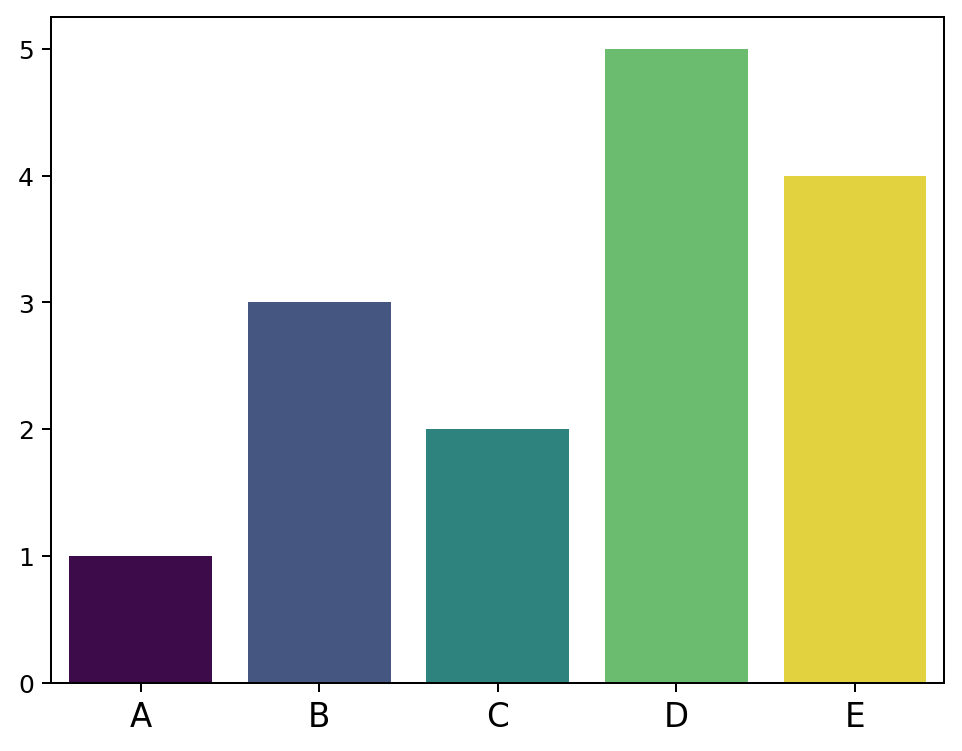

In [50]:
# first plot a bar chart for F1 MCC for all models
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_hex
import pandas as pd
from src.utils import mean_confidence_interval
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
plt.rcParams.update({
    "font.size": 12,  
    # Base font size
    "axes.titlesize": 16,      # Axis title font size
    "axes.labelsize": 15,      # Axis label font size
    "xtick.labelsize": 13,     # X-axis tick label font size
    "ytick.labelsize": 10      # Y-axis tick label font size
})
n_colors = 5
viridis = plt.cm.viridis
colors = [to_hex(viridis(i)) for i in np.linspace(0, 1, n_colors)]

# Apply the palette
custom_palette = sns.color_palette(colors)

# Example plot
sns.set_palette(custom_palette)
sns.barplot(x=["A", "B", "C", "D", "E"], y=[1, 3, 2, 5, 4])
plt.show()

In [51]:
mm165_pandey_pcc, mm165_pandey_ci = mean_confidence_interval(mm165_pandey_pcc)
mm23_pandey_pcc, mm23_pandey_ci = mean_confidence_interval(mm23_pandey_pcc)
casp12_pandey_pcc, casp12_pandey_ci = mean_confidence_interval(casp12_pandey_pcc)
mm165_pandey_RR_pcc, mm165_pandey_RR_ci = mean_confidence_interval(mm165_pandey_RR_pcc)
mm23_pandey_RR_pcc, mm23_pandey_RR_ci = mean_confidence_interval(mm23_pandey_RR_pcc)
casp12_pandey_RR_pcc, casp12_pandey_RR_ci = mean_confidence_interval(casp12_pandey_RR_pcc)

In [53]:
import src.models as mm
sasa_labels = pd.read_csv('data/e_prsa/bfactor/train_with_uni.tsv', sep='\t')['norm_Bfactor'].values
dummy_model = mm.SASADummyModel(1, torch.tensor(sasa_labels)).cpu()
trainer = pl.Trainer(enable_progress_bar=False, accelerator='cpu')

pred = trainer.predict(dummy_model, DataLoader(BDataset(MM165_emb, MM165_bfactor, MM165_pids), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'MM165: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(MM23_emb, MM23_bfactor, MM23_pids), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'MM23: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(casp12_emb, casp12_bfactor, casp12_pids), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'CASP12: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(CASP15_emb, CASP15_bfactor, CASP15_pids), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'CASP15: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(cameo65_emb, cameo65_bfactor, cameo65_pids), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'CAMEO65: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(cameo82_emb, cameo82_bfactor, cameo82_pids), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'CAMEO82: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


MM165: PCC: 0.011638697074764887 +/- 0.014092344231365312, MAE: 1.0273665260847284 +/- 0.011278962342526962
MM23: PCC: -0.01279866259671605 +/- 0.026110849948866005, MAE: 1.0330523466111672 +/- 0.024351813893738743
CASP12: PCC: 0.024874407783285195 +/- 0.034382338877106476, MAE: 1.0371052802270027 +/- 0.03326857615793675
CASP15: PCC: -0.00785613130243462 +/- 0.02243005480075557, MAE: 1.0286574620332072 +/- 0.02480798434066473
CAMEO65: PCC: -0.0006335223531370694 +/- 0.02287653593145809, MAE: 1.0381574575487262 +/- 0.017280350998446735
CAMEO82: PCC: -0.006715693120325679 +/- 0.015065412117860522, MAE: 1.0317322851878612 +/- 0.015431534913438044


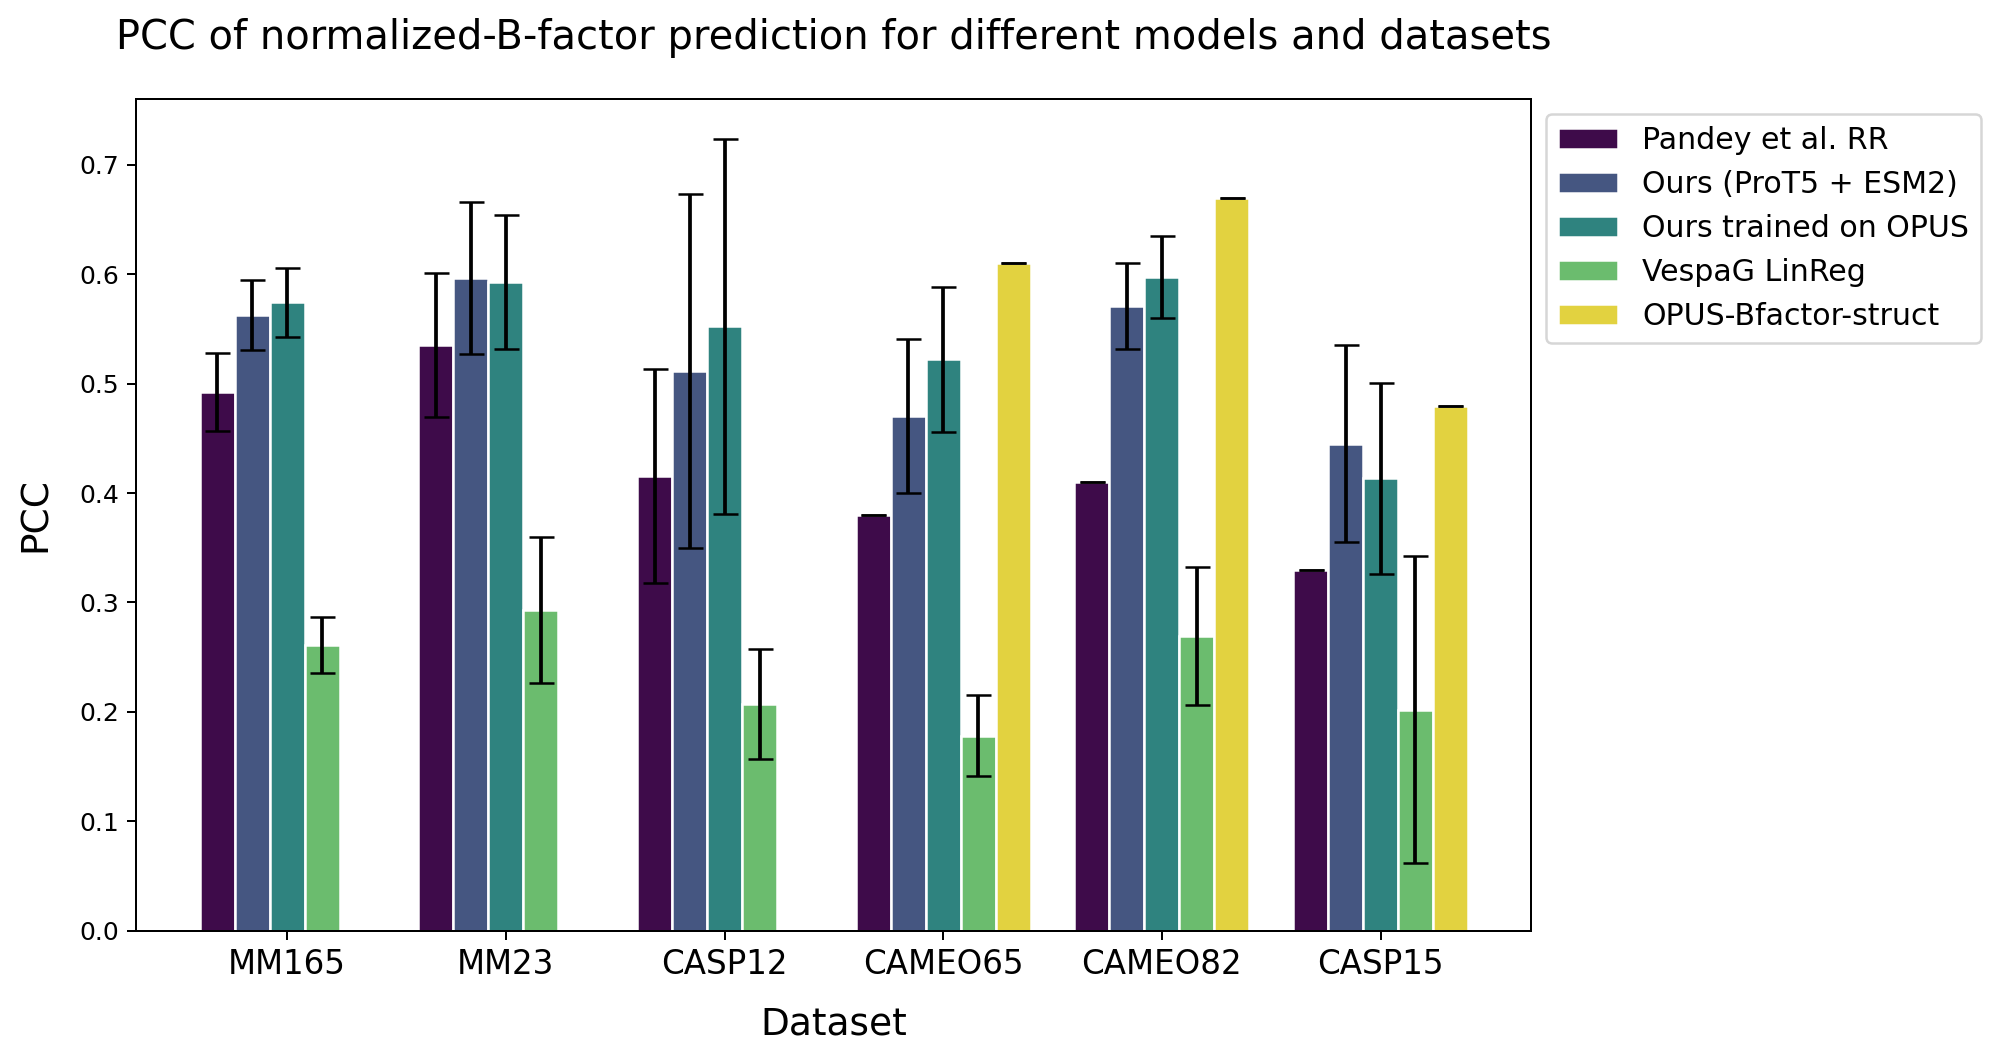

In [54]:
'''
VespaG LinReg
MM165 PCC: (0.2607606667970004, 0.025602783600770306)
MM23 PCC: (0.2928752330313126, 0.06708715330998814)
CAMEO65 PCC: (0.17828917540498695, 0.049607133881141886)
CAMEO82 PCC: (0.26895240077690974, 0.036521980833105615)
CASP15 PCC: (0.20214166505576295, 0.06333958172373773)
CASP12 PCC: (0.2067206710745617, 0.14015724473871405)
'''
'''
Our CNN
MM165: MAE: 0.6112818410405138, PCC: 0.5629544854164124
MM23: MAE:0.5962098647392294, PCC:0.5841466188430786
CAMEO65: MAE:0.6802896763500835, PCC:0.4646990895271301
CAMEO82: MAE:0.6028958408070683, PCC:0.5682239532470703
CASP15: MAE:0.6806828086738469, PCC:0.441807359457016
'''
'''
Our CNN OPUS train data
MM165: MAE: 0.6000550644126632, PCC: 0.5669728517532349
MM23: MAE:0.5887034476216151, PCC:0.589452862739563
CAMEO65: MAE:0.6502543380088786, PCC:0.5208668112754822
CAMEO82: MAE:0.5814854716831097, PCC:0.5934268832206726
CASP15: MAE:0.684480693618281, PCC:0.3992024064064026
'''
'''
Pandey et al. 
MM165: PCC 0.49250788750282926
MM23: PCC 0.5351993122171502
CAMEO65: PCC 0.38
CAMOE82: PCC 0.41
CAS15: PCC 0.33
'''
'''
OPUS-Bfactor
CAMOE65: PCC 0.61
CAMOE82: PCC 0.67
CASP15: PCC 0.48
'''
'''
Random Baseline
MM165: PCC: 0.011638697074764887 +/- 0.014092344231365312, MAE: 1.0273665260847284 +/- 0.011278962342526962
MM23: PCC: -0.01279866259671605 +/- 0.026110849948866005, MAE: 1.0330523466111672 +/- 0.024351813893738743
CASP12: PCC: 0.024874407783285195 +/- 0.034382338877106476, MAE: 1.0371052802270027 +/- 0.03326857615793675
CASP15: PCC: -0.00785613130243462 +/- 0.02243005480075557, MAE: 1.0286574620332072 +/- 0.02480798434066473
CAMEO65: PCC: -0.0006335223531370694 +/- 0.02287653593145809, MAE: 1.0381574575487262 +/- 0.017280350998446735
CAMEO82: PCC: -0.006715693120325679 +/- 0.015065412117860522, MAE: 1.0317322851878612 +/- 0.015431534913438044
'''

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pandey_rr_ci = {
    'MM165': mm165_pandey_RR_ci,
    'MM23': mm23_pandey_RR_ci,
    'CASP12': casp12_pandey_RR_ci,
    'CAMEO65': 0.00,
    'CAMEO82': 0.00,
    'CASP15': 0.00
}
pandey_rr_pcc = {
    'MM165': mm165_pandey_RR_pcc,
    'MM23': mm23_pandey_RR_pcc,
    'CASP12': casp12_pandey_RR_pcc,
    'CAMEO65': 0.38,
    'CAMEO82': 0.41,
    'CASP15': 0.33
}

our_cnn_pcc = {
    'MM165': mm165_subset_pcc,
    'MM23': mm23_subset_pcc,
    'CASP12': casp12_subset_pcc,
    'CAMEO65': cameo65_subset_pcc,
    'CAMEO82': cameo82_subset_pcc,
    'CASP15': CASP15_subset_pcc
}
our_cnn_ci = {
    'MM165': mm165_subset_pcc_ci,
    'MM23': mm23_subset_pcc_ci,
    'CASP12': casp12_subset_pcc_ci,
    'CAMEO65': cameo65_subset_pcc_ci,
    'CAMEO82': cameo82_subset_pcc_ci,
    'CASP15': CASP15_subset_pcc_ci
}
our_opus_cnn_pcc = {
    'MM165': mm165_subset_pcc_opus,
    'MM23': mm23_subset_pcc_opus,
    'CASP12': casp12_subset_pcc_opus,
    'CAMEO65': cameo65_subset_pcc_opus,
    'CAMEO82': cameo82_subset_pcc_opus,
    'CASP15': CASP15_subset_pcc_opus
}
our_opus_cnn_ci = {
    'MM165': mm165_subset_pcc_ci_opus,
    'MM23': mm23_subset_pcc_ci_opus,
    'CASP12': casp12_subset_pcc_ci_opus,
    'CAMEO65': cameo65_subset_pcc_ci_opus,
    'CAMEO82': cameo82_subset_pcc_ci_opus,
    'CASP15': CASP15_subset_pcc_ci_opus
}
opus_bfactor_pcc = {
    'CAMEO65': 0.61,
    'CAMEO82': 0.67,
    'CASP15': 0.48,
    'MM165': 0.00,
    'MM23': 0.00,
    'CASP12': 0.00
}
opus_bfactor_ci = {
    'CAMEO65': 0.00,
    'CAMEO82': 0.00,
    'CASP12': 0.00,
    'CASP15': 0.00,
    'MM165': 0.00,
    'MM23': 0.00
}
baseline_pcc = {    
    'MM165': 0.261,
    'MM23': 0.293,
    'CAMEO65': 0.178,
    'CAMEO82': 0.269,
    'CASP15': 0.202,
    'CASP12': 0.207
}
baseline_ci = {
    'MM165': 0.026,
    'MM23': 0.067,
    'CAMEO65': 0.050,
    'CAMEO82': 0.037,
    'CASP15': 0.063,
    'CASP12': 0.140
    
}
random_baseline_pcc = {
    'MM165': 0.011,
    'MM23': -0.013,
    'CASP12': 0.025,
    'CASP15': -0.008,
    'CAMEO65': -0.001,
    'CAMEO82': -0.007
}
random_baseline_ci = {
    'MM165': 0.014,
    'MM23': 0.026,
    'CASP12': 0.034,
    'CASP15': 0.022,
    'CAMEO65': 0.023,
    'CAMEO82': 0.015
}
                

pandey = pd.DataFrame(pandey_rr_pcc.items(), columns=['Dataset', 'PCC'])
pandey['Model'] = 'Pandey et al. RR'
pandey['CI'] = pandey_rr_ci.values()
our_cnn = pd.DataFrame(our_cnn_pcc.items(), columns=['Dataset', 'PCC'])
our_cnn['Model'] = 'Ours (ProT5 + ESM2)'
our_cnn['CI'] = our_cnn_ci.values()
our_opus_cnn = pd.DataFrame(our_opus_cnn_pcc.items(), columns=['Dataset', 'PCC'])
our_opus_cnn['Model'] = 'Ours trained on OPUS'
our_opus_cnn['CI'] = our_opus_cnn_ci.values()
opus_bfactor = pd.DataFrame(opus_bfactor_pcc.items(), columns=['Dataset', 'PCC'])
opus_bfactor['Model'] = 'OPUS-Bfactor-struct'
opus_bfactor['CI'] = opus_bfactor_ci.values()
baseline = pd.DataFrame(baseline_pcc.items(), columns=['Dataset', 'PCC'])
baseline['Model'] = 'VespaG LinReg'
baseline['CI'] = baseline_ci.values()
random_baseline = pd.DataFrame(random_baseline_pcc.items(), columns=['Dataset', 'PCC'])
random_baseline['Model'] = 'Random Baseline'
random_baseline['CI'] = random_baseline_ci.values()

df = pd.concat([pandey, our_cnn, our_opus_cnn, baseline, opus_bfactor])


fig, ax = plt.subplots(figsize=(10, 6))
barplot = sns.barplot(x='Dataset', y='PCC', hue='Model', data=df, ax=ax, edgecolor='white', palette=custom_palette)
for i, bar in enumerate(barplot.patches):
    # Get the center of the bar
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    # Get the corresponding CI value
    ci = df.iloc[i]['CI']
    # Add error bar
    ax.errorbar(x, y, yerr=ci, fmt='none', c='black', capsize=5)


plt.ylabel('PCC', labelpad=10)
plt.xlabel('Dataset', labelpad=10)
plt.title('PCC of normalized-B-factor prediction for different models and datasets', pad=20) 
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.savefig('results/plots/bfactor_pcc.png', dpi=300, bbox_inches='tight')
plt.show()





In [61]:
df = pd.concat([pandey, our_cnn, our_opus_cnn, baseline, opus_bfactor, random_baseline])
# make dataset names to column names, show only 3 decimals and include confidence intervals
df_dataset = df.pivot(index='Model', columns='Dataset', values='PCC').T
df_dataset = df_dataset.applymap(lambda x: f'{x:.3f}')
df_ci = df.pivot(index='Model', columns='Dataset', values='CI').T
df_ci = df_ci.applymap(lambda x: f'{x:.3f}')
df = df_dataset + ' +/- ' + df_ci

In [65]:
df.T

Dataset,CAMEO65,CAMEO82,CASP12,CASP15,MM165,MM23
Model,,,,,,
OPUS-Bfactor-struct,0.610 +/- 0.000,0.670 +/- 0.000,0.000 +/- 0.000,0.480 +/- 0.000,0.000 +/- 0.000,0.000 +/- 0.000
Ours (ProT5 + ESM2),0.471 +/- 0.070,0.571 +/- 0.040,0.512 +/- 0.162,0.445 +/- 0.090,0.563 +/- 0.032,0.597 +/- 0.069
Ours trained on OPUS,0.522 +/- 0.066,0.597 +/- 0.037,0.552 +/- 0.172,0.413 +/- 0.088,0.574 +/- 0.032,0.593 +/- 0.061
Pandey et al. RR,0.380 +/- 0.000,0.410 +/- 0.000,0.416 +/- 0.098,0.330 +/- 0.000,0.493 +/- 0.036,0.535 +/- 0.066
Random Baseline,-0.001 +/- 0.023,-0.007 +/- 0.015,0.025 +/- 0.034,-0.008 +/- 0.022,0.011 +/- 0.014,-0.013 +/- 0.026
VespaG LinReg,0.178 +/- 0.050,0.269 +/- 0.037,0.207 +/- 0.140,0.202 +/- 0.063,0.261 +/- 0.026,0.293 +/- 0.067


In [67]:
sasa_labels = pd.read_csv('data/e_prsa/bfactor/train_with_uni.tsv', sep='\t')['norm_Bfactor'].values
dummy_model = mm.SASADummyModel(1, torch.tensor(sasa_labels)).cpu()
trainer = pl.Trainer(enable_progress_bar=False, accelerator='cpu')

pred = trainer.predict(dummy_model, DataLoader(BDataset(MM165_emb_subset, MM165_bfactor_subset, MM165_pids_subset), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'MM165_subset: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(MM23_emb_subset, MM23_bfactor_subset, MM23_pids_subset), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'MM23_subset: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(casp12_emb_subset, casp12_bfactor_subset, casp12_pids_subset), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'CASP12_subset: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(CASP15_emb_subset, CASP15_bfactor_subset, CASP15_pids_subset), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'CASP15_subset: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(cameo65_emb_subset, cameo65_bfactor_subset, cameo65_pids_subset), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'CAMEO65_subset: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(cameo82_emb_subset, cameo82_bfactor_subset, cameo82_pids_subset), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'CAMEO82_subset: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')



GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


MM165_subset: PCC: -0.0007326400564963338 +/- 0.011980110817345055, MAE: 1.0312472111122934 +/- 0.0119130528974463
MM23_subset: PCC: -0.00018199032832525304 +/- 0.033951280252693304, MAE: 1.02773031131707 +/- 0.02513443649016436
CASP12_subset: PCC: -0.013976726396356262 +/- 0.08384197119430194, MAE: 1.0335397486136992 +/- 0.0407029478095044
CASP15_subset: PCC: 0.02847620813961079 +/- 0.031823937413822743, MAE: 1.0245003675372055 +/- 0.031542270264011435
CAMEO65_subset: PCC: -0.0006469027362409901 +/- 0.022607568437396922, MAE: 1.0303586701073986 +/- 0.019607715823925977
CAMEO82_subset: PCC: 0.009139869046646045 +/- 0.017457648133609307, MAE: 1.018079424536219 +/- 0.012469614132023518


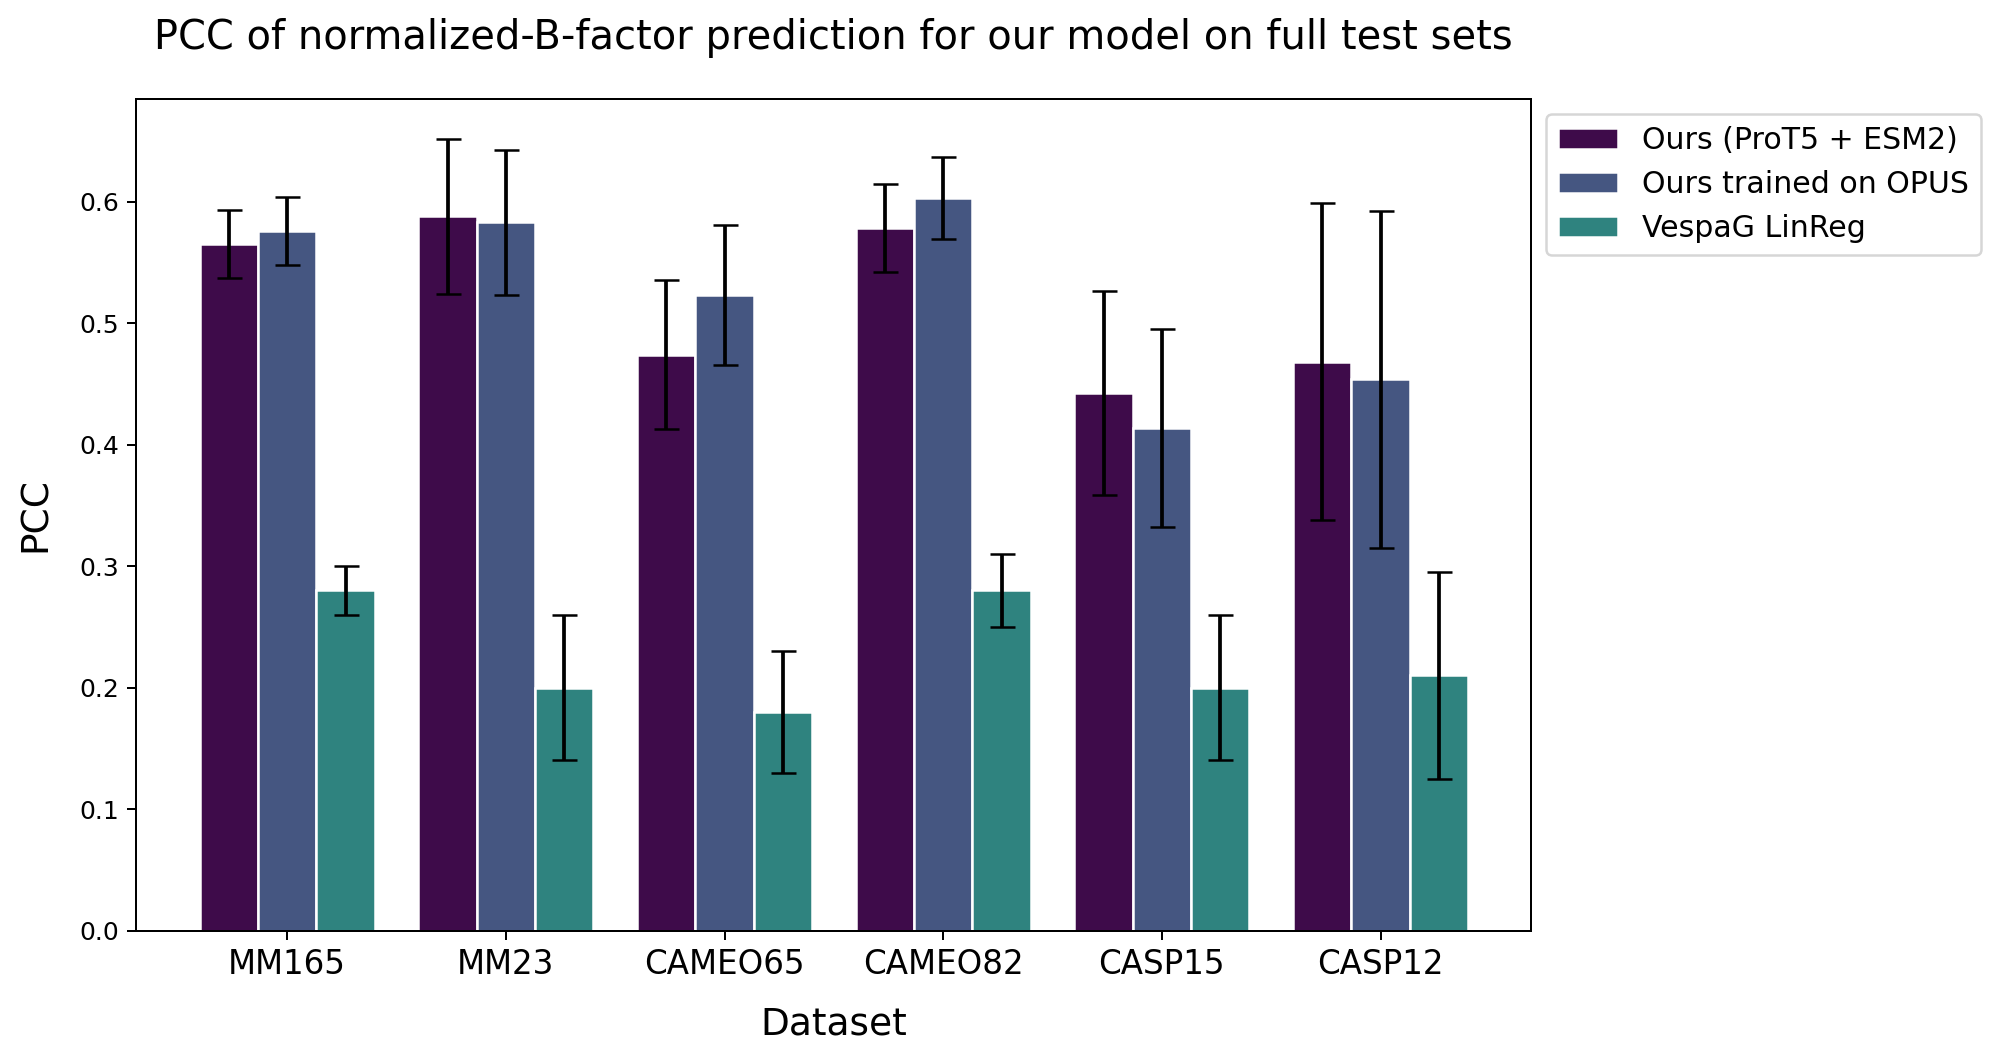

In [68]:
'''
VespaG LinReg
MM165 PCC: (0.26735907855035146, 0.023596573849915443)
MM23 PCC: (0.3046447172381102, 0.06136170268823408)
CAMEO65 PCC: (0.17798689447056693, 0.04532211696434146)
CAMEO82 PCC: (0.2794304211094896, 0.03396005023201665)
CASP15 PCC: (0.20186199233589733, 0.05983327675943999)
CASP12 PCC: (0.21626070192292804, 0.08576248403836709)
'''
'''
Random Baseline
MM165_subset: PCC: -0.0007326400564963338 +/- 0.011980110817345055, MAE: 1.0312472111122934 +/- 0.0119130528974463
MM23_subset: PCC: -0.00018199032832525304 +/- 0.033951280252693304, MAE: 1.02773031131707 +/- 0.02513443649016436
CASP12_subset: PCC: -0.013976726396356262 +/- 0.08384197119430194, MAE: 1.0335397486136992 +/- 0.0407029478095044
CASP15_subset: PCC: 0.02847620813961079 +/- 0.031823937413822743, MAE: 1.0245003675372055 +/- 0.031542270264011435
CAMEO65_subset: PCC: -0.0006469027362409901 +/- 0.022607568437396922, MAE: 1.0303586701073986 +/- 0.019607715823925977
CAMEO82_subset: PCC: 0.009139869046646045 +/- 0.017457648133609307, MAE: 1.018079424536219 +/- 0.012469614132023518
'''

our_cnn_pcc = {
    'MM165': mm165_pcc,
    'MM23': mm23_pcc,
    'CAMEO65': cameo65_pcc,
    'CAMEO82': cameo82_pcc,
    'CASP15': CASP15_pcc,
    'CASP12': casp12_pcc
}
our_cnn_ci = {
    'MM165': mm165_pcc_ci,
    'MM23': mm23_pcc_ci,
    'CAMEO65': cameo65_pcc_ci,
    'CAMEO82': cameo82_pcc_ci,
    'CASP15': CASP15_pcc_ci,
    'CASP12': casp12_pcc_ci
}
our_opus_cnn_pcc = {
    'MM165': mm165_pcc_opus,
    'MM23': mm23_pcc_opus,
    'CAMEO65': cameo65_pcc_opus,
    'CAMEO82': cameo82_pcc_opus,
    'CASP15': CASP15_pcc_opus,
    'CASP12': casp12_pcc_opus
}
our_opus_cnn_ci = {
    'MM165': mm165_pcc_ci_opus,
    'MM23': mm23_pcc_ci_opus,
    'CAMEO65': cameo65_pcc_ci_opus,
    'CAMEO82': cameo82_pcc_ci_opus,
    'CASP15': CASP15_pcc_ci_opus,
    'CASP12': casp12_pcc_ci_opus
}

baseline_pcc = {
    'MM165': 0.28,
    'MM23': 0.20,
    'CAMEO65': 0.18,
    'CAMEO82': 0.28,
    'CASP15': 0.20,
    'CASP12': 0.21
}
baseline_ci = {
    'MM165': 0.02,
    'MM23': 0.06,
    'CAMEO65': 0.05,
    'CAMEO82': 0.03,
    'CASP15': 0.06,
    'CASP12': 0.085
}
    
random_baseline_pcc = {
    'MM165_subset': -0.001,
    'MM23_subset': -0.000,
    'CAMEO65_subset': -0.001,
    'CAMEO82_subset': 0.009,
    'CASP15_subset': 0.028,
    'CASP12_subset': -0.014
}

random_baseline_ci = {
    'MM165_subset': 0.012,
    'MM23_subset': 0.034,
    'CAMEO65_subset': 0.023,
    'CAMEO82_subset': 0.017,
    'CASP15_subset': 0.032,
    'CASP12_subset': 0.084
}


our_cnn = pd.DataFrame(our_cnn_pcc.items(), columns=['Dataset', 'PCC'])
our_cnn['Model'] = 'Ours (ProT5 + ESM2)'
our_cnn['CI'] = our_cnn_ci.values()
our_opus_cnn = pd.DataFrame(our_opus_cnn_pcc.items(), columns=['Dataset', 'PCC'])
our_opus_cnn['Model'] = 'Ours trained on OPUS'
our_opus_cnn['CI'] = our_opus_cnn_ci.values()
baseline = pd.DataFrame(baseline_pcc.items(), columns=['Dataset', 'PCC'])
baseline['Model'] = 'VespaG LinReg'
baseline['CI'] = baseline_ci.values()

df = pd.concat([our_cnn, our_opus_cnn, baseline])


fig, ax = plt.subplots(figsize=(10, 6))
barplot = sns.barplot(x='Dataset', y='PCC', hue='Model', data=df, ax=ax, edgecolor='white', palette=custom_palette)
for i, bar in enumerate(barplot.patches):
    # Get the center of the bar
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    # Get the corresponding CI value
    ci = df.iloc[i]['CI']
    # Add error bar
    ax.errorbar(x, y, yerr=ci, fmt='none', c='black', capsize=5)


plt.ylabel('PCC', labelpad=10)
plt.xlabel('Dataset', labelpad=10)
plt.title('PCC of normalized-B-factor prediction for our model on full test sets', pad=20) 
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.savefig('results/plots/bfactor_pcc_full_test.png', dpi=300, bbox_inches='tight')
plt.show()

### Random Baseline

In [70]:
df = pd.concat([our_cnn, our_opus_cnn, baseline, random_baseline])
df_dataset = df.pivot(index='Model', columns='Dataset', values='PCC').T
df_dataset = df_dataset.applymap(lambda x: f'{x:.3f}')
df_ci = df.pivot(index='Model', columns='Dataset', values='CI').T
df_ci = df_ci.applymap(lambda x: f'{x:.3f}')
df = df_dataset + ' +/- ' + df_ci
df.T

Dataset,CAMEO65,CAMEO82,CASP12,CASP15,MM165,MM23
Model,,,,,,
Ours (ProT5 + ESM2),0.474 +/- 0.061,0.578 +/- 0.036,0.468 +/- 0.130,0.442 +/- 0.084,0.565 +/- 0.028,0.588 +/- 0.064
Ours trained on OPUS,0.523 +/- 0.058,0.603 +/- 0.034,0.454 +/- 0.139,0.413 +/- 0.081,0.576 +/- 0.028,0.583 +/- 0.060
Random Baseline,-0.001 +/- 0.023,-0.007 +/- 0.015,0.025 +/- 0.034,-0.008 +/- 0.022,0.011 +/- 0.014,-0.013 +/- 0.026
VespaG LinReg,0.180 +/- 0.050,0.280 +/- 0.030,0.210 +/- 0.085,0.200 +/- 0.060,0.280 +/- 0.020,0.200 +/- 0.060
